# **Requerimientos**

In [ ]:
!pip install astroquery
!pip install alerce
!pip install P4J

In [ ]:
from alerce.core import Alerce
alerce=Alerce()
import numpy as np; import matplotlib.pyplot as plt
import sys ; import pandas as pd
import seaborn as sns; import os
import requests; import astropy.units as u

from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance, Galactic, SkyCoord
from astropy.cosmology import WMAP7
from astroquery.ipac.irsa.irsa_dust import IrsaDust
from astroquery.ned import Ned
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from astroquery.simbad import Simbad
import P4J

# **Muestra de rr**

In [ ]:
lyraes = [ "ZTF18aajusiz", "ZTF18aalarzm", "ZTF18aapmpdr", "ZTF18aapsyhm","ZTF18abjlrkf"]

**Funciones ind**

In [ ]:
def plotLC(oid, VS_det):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                linestyle='None')


    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def plot_diffLC(oid, LC_det, LC_nondet):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf,
                yerr = LC_det[mask].sigmapsf, c = colors[fid], fmt=markers[fid], label = labels[fid])

        # plot non detections if available and if wanted:
        mask = (LC_nondet.fid == fid) & (LC_nondet.diffmaglim > -900)
        if (np.sum(mask) > 0):
            # non detections index is mjd
            ax.scatter(LC_nondet[mask].mjd, LC_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])

    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("difference magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.show()

def plot_corrLC(oid, LC_det):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])


    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def get_DR(oid, url="https://api.alerce.online/ztf/dr/v1/light_curve/"):
    stats = alerce.query_object(oid, format='pandas')

    ra = float(stats.meanra)
    dec = float(stats.meandec)
    query = {'ra':ra, 'dec':dec, 'radius':1.5}

    response = requests.get(url, query)
    output = response.json()

    df = []
    for i in output:
        aux = pd.DataFrame({'hmjd': np.array(i["hmjd"]), 'mag': np.array(i["mag"]), "magerr": np.array(i["magerr"])})
        aux["ID"] = int(i["_id"])
        aux["filterid"] = int(i["filterid"])
        aux["oid"] = oid
        df.append(aux)

    if df != []:
        return pd.concat(df) #output
    else:
        return None

In [ ]:
DR = get_DR(lyraes[0])

<ipython-input-52-706504d779bf>:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ra = float(stats.meanra)
<ipython-input-52-706504d779bf>:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dec = float(stats.meandec)


In [ ]:
def plot_corrLC_DR(oid, LC_det, DR):

    fig, ax = plt.subplots(figsize = (14, 8))
    labels = {1: 'g', 2: 'r'}
    labels1 = {1: 'g DR', 2: 'r DR'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    colors1 = {1: '#ADA3A3', 2: '#377EB8',}
    markers = {1: 'o', 2: 's'}

    # loop the passbands
    for fid in [1, 2]:

        # plot detections if available
        mask = LC_det.fid == fid
        maskDR = DR.filterid == fid
        if np.sum(mask) > 0:
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            ax.errorbar(DR[maskDR].hmjd, DR[maskDR].mag,
                yerr = DR[maskDR].magerr, c = colors1[fid], fmt=markers[fid], label = labels1[fid], alpha=.3)
            ax.errorbar(LC_det[mask].mjd, LC_det[mask].magpsf_corr,
                yerr = LC_det[mask].sigmapsf_corr_ext, c = colors[fid], fmt=markers[fid], label = labels[fid])



    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

def getLCdata(oid, doLC = False,  plot_diff = False, doDR = False):

    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    results = {"oid": oid}

    # query detections
    LC_det = alerce.query_detections(oid, format='pandas')
    results["lc_det"] = LC_det

    # query non detections
    LC_nondet = alerce.query_non_detections(oid, format='pandas')
    results["lc_nondet"] = LC_nondet

    # plot the LC
    if doLC:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC(oid, LC_det)

    # plot the LC
    if doDR:
        if plot_diff:
            plot_diffLC(oid, LC_det, LC_nondet)
        else:
            plot_corrLC_DR(oid, LC_det, DR)

    # return data
    return results

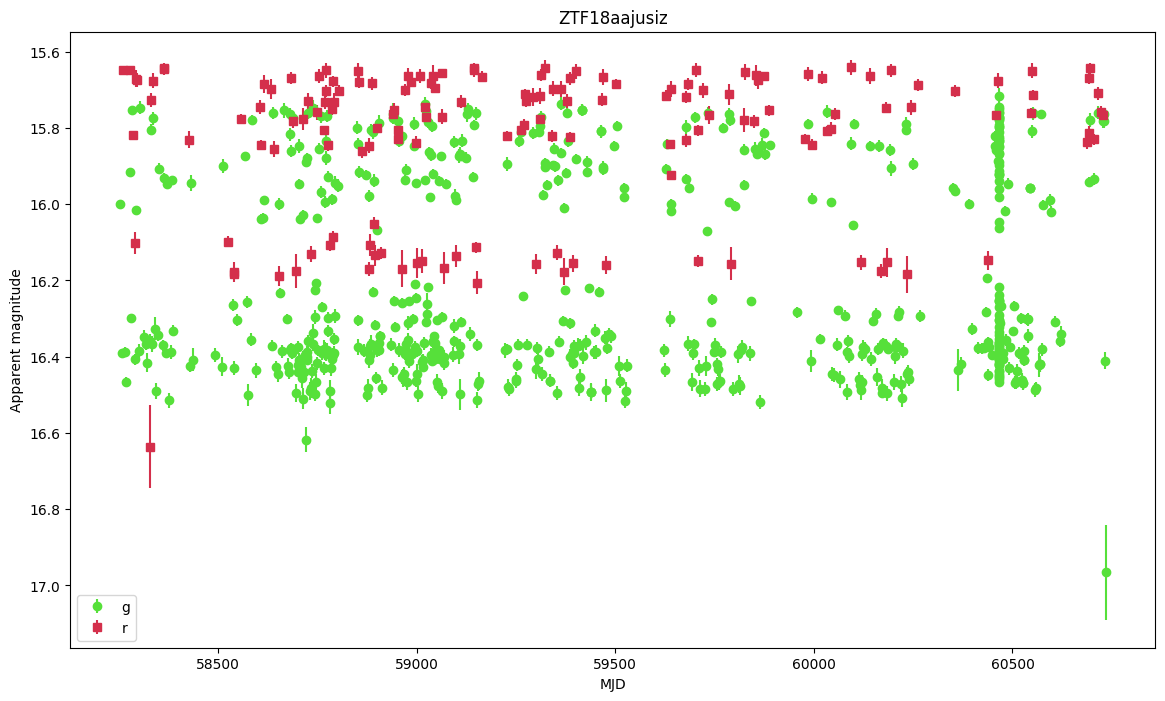

In [ ]:
results = getLCdata(lyraes[0], doLC=True, plot_diff = False)

In [ ]:
def plotLCcorr(oid, VS_det, A=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    colors = {1: '#56E03A', 2: '#D42F4B'}
    sizes = {1: 30, 2: 40}

    # loop the passbands
    for fid in [1, 2]:

        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = VS_det.fid == fid
        if np.sum(mask) > 0:

            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    alpha=0.1, linestyle='None')
                # show dust attenuation corrected light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr - A_fid,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid],
                    label="%s (ext. corr.)" % labels[fid], linestyle='None')
            else:
                # plot attenuated light curve
                ax.errorbar(VS_det[mask].mjd, VS_det[mask].magpsf_corr,
                    yerr=VS_det[mask].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')

    # labels
    if A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)

    ax.set_xlabel("MJD")
    ax.set_ylabel("Apparent magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [ ]:
def getVSdatacorr(oid, doLC=False, doext=False, dostamp=False, dosimbad=False, showlink=False):

    results = {"oid": oid}

    # query basic stats
    VS_stats = alerce.query_object(oid, format='pandas')
    results["stats"] = VS_stats

    # query magnitude stats
    VS_magstats = alerce.query_magstats(oid, format='pandas')
    results["magstats"] = VS_magstats

    # query detections
    VS_det = alerce.query_detections(oid, format='pandas')
    VS_det = VS_det.sort_values("mjd")
    results["lc_det"] = VS_det

    # object coordinates
    co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
                              frame='icrs')

    # get SIMBAD query
    if dosimbad:
        Simbad_table = Simbad.query_region(co, radius=0.01 * u.deg, equinox=2000)
        display(Simbad_table)
        results["simbad_table"] = Simbad_table

    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
             "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A

    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, VS_det, A)
        else:
            plotLCcorr(oid, VS_det)

    if showlink:
        display(HTML("<a href='http://dev.alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    # show the first image stamp
    if dostamp:
        candid = results["lc_det"].loc[results["lc_det"].has_stamp].candid.min()
        stamps = alerce.get_stamps(oid, candid)
        science, ref, difference = stamps[0].data, stamps[1].data, stamps[2].data
        fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
        for idx, im in enumerate([np.log(science), np.log(ref), difference]):
            ax[idx].imshow(im, cmap='viridis') # Log scale for visualization
            ax[idx].axes.get_xaxis().set_visible(False)
            ax[idx].axes.get_yaxis().set_visible(False)
        ax[0].set_title("oid: %s, candid: %s (science, reference and difference)" % (oid, candid), loc='left')
        fig.subplots_adjust(wspace=0, hspace=0)

    return results

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-57-1266541ed3b0>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-57-1266541ed3b0>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}


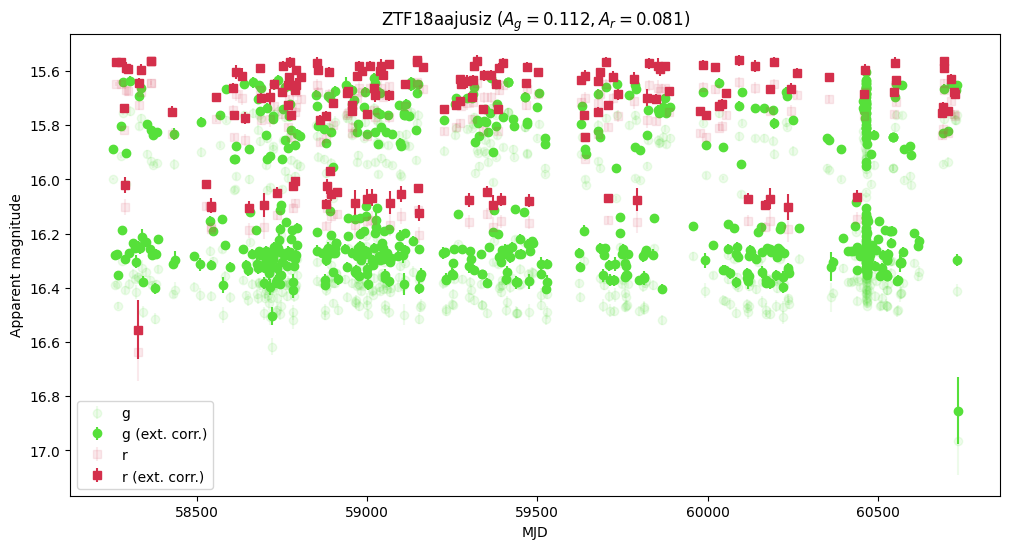

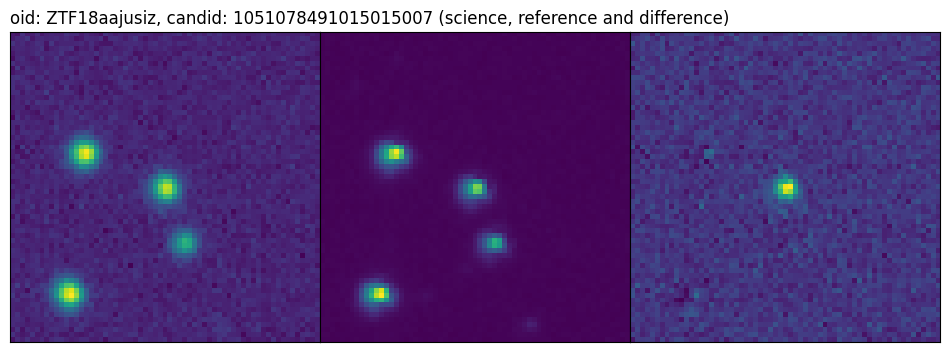

In [ ]:
results = getVSdatacorr(lyraes[0], doLC=True, doext=True, dostamp=True, showlink=True)

**Periodo**

In [ ]:
def doperiod_multiband(VS_det, showperiod=False):

    mjds, mags, errs, fids = VS_det[["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

    # Compute periodogram
    my_per = P4J.MultiBandPeriodogram(method='MHAOV')
    my_per.set_data(mjds, mags, errs, fids)
    my_per.frequency_grid_evaluation(fmin=1e-3, fmax=20.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)

    best_freq, best_per = my_per.get_best_frequencies()
    freq_mb, per_mb = my_per.get_periodogram()
    period_mb = 1.0 / best_freq[0]

    if showperiod:
        print('Multiband period: %.6f days' % period_mb)

    period = {}
    freq = {}
    per = {}
    labels = {1: 'g', 2: 'r'}

    for fid in [1, 2]:
        freq[fid], per[fid] = my_per.get_periodogram(fid)
        best_freq = my_per.get_best_frequency(fid)
        period[fid] = 1. / best_freq

        if showperiod:
            print("Period %s: %.6f days" % (labels[fid], period[fid]))

    return period_mb, freq_mb, per_mb, period, freq, per

def plotperiod_multiband(oid, VS_det, dofold=False, showperiodograms=False,
                         period_mb=None, freq_mb=None, per_mb=None,
                         period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize=(12, 6))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}

    for idx, fid in enumerate([1, 2]):
        maskdet = VS_det.fid == fid
        colors = {1: '#56E03A', 2: '#D42F4B'}

        if dofold:
            phase = np.mod(VS_det[maskdet].mjd, period_mb) / period_mb
            for nphase in [0, 1]:
                if nphase == 0:
                    label = labels[fid]
                else:
                    label = None
                ax.errorbar(phase + nphase, VS_det[maskdet].magpsf_corr,
                        yerr = VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=label,
                        markersize=5, linestyle='None')
        else:
            ax.errorbar(VS_det[maskdet].mjd, VS_det[maskdet].magpsf_corr,
                    yerr=VS_det[maskdet].sigmapsf_corr_ext, c=colors[fid], marker=markers[fid], label=labels[fid],
                    linestyle='None')

    if dofold:
        ax.set_title("%s (multiband period: %.6f days)" % (oid, period_mb))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

    if dofold and showperiodograms:
        fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

        for idx, fid in enumerate([0, 1, 2]):
            if idx==0:
                ax[idx].plot(freq_mb, per_mb)
                ax[idx].set_title("Multiband periodogram")
                ax[idx].set_xlabel("frequency [1/days]")
            else:
                ax[idx].plot(freq[fid], per[fid])
                ax[idx].set_title("Periodogram %s (period: %.6f days)" % (labels[fid], period[fid]))
                ax[idx].set_xlabel("frequency [1/days]")

def getLCdata(oid, results, doplot=False, dofold=False, showperiod=False, showperiodograms=False):
    if dofold:
        # get period
        period_mb, freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"],
                                                                           showperiod=showperiod)
        results["period_multiband"] = period_mb
        results["period_band"] = period
    else:
        period = None; freq = None; per = None
        period_mb = None; freq_mb = None; per_mb = None

    if doplot:
        plotperiod_multiband(oid, results["lc_det"], dofold, showperiodograms,
                             period_mb=period_mb, freq_mb=freq_mb, per_mb=per_mb,
                             period=period, freq=freq, per=per)

    return results

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),


Multiband period: 0.678794 days
Period g: 0.678794 days
Period r: 0.678794 days


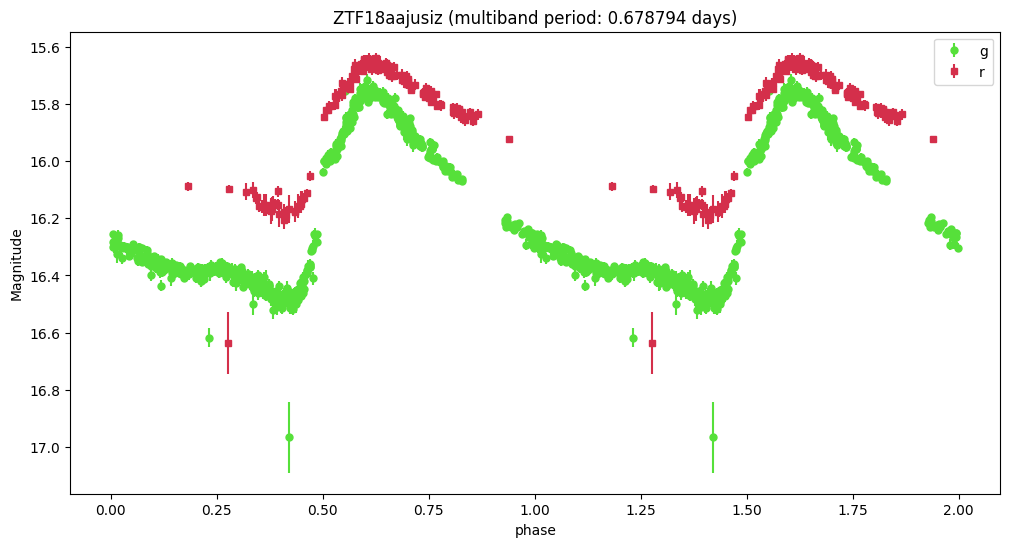

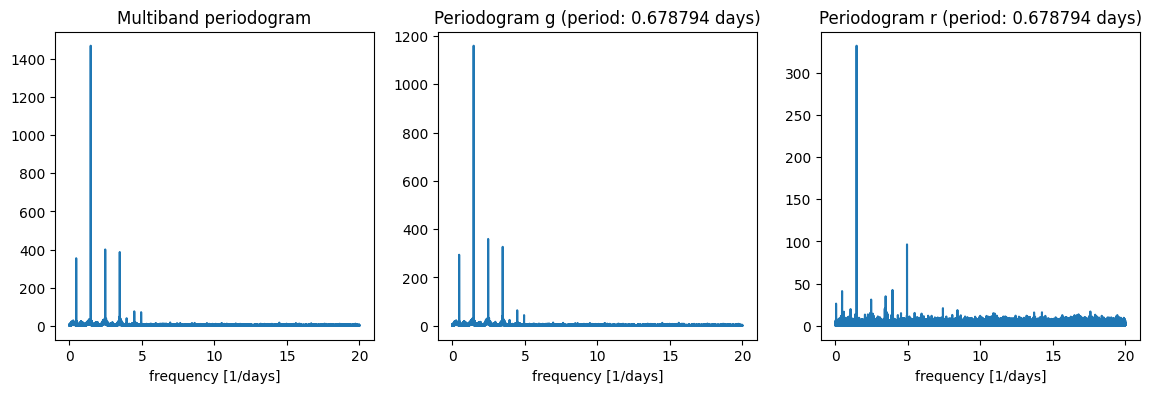

In [ ]:
results = getVSdatacorr(lyraes[0])
periodogram = getLCdata(lyraes[0], results, doplot=True, dofold=True, showperiod=True, showperiodograms=True)

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),


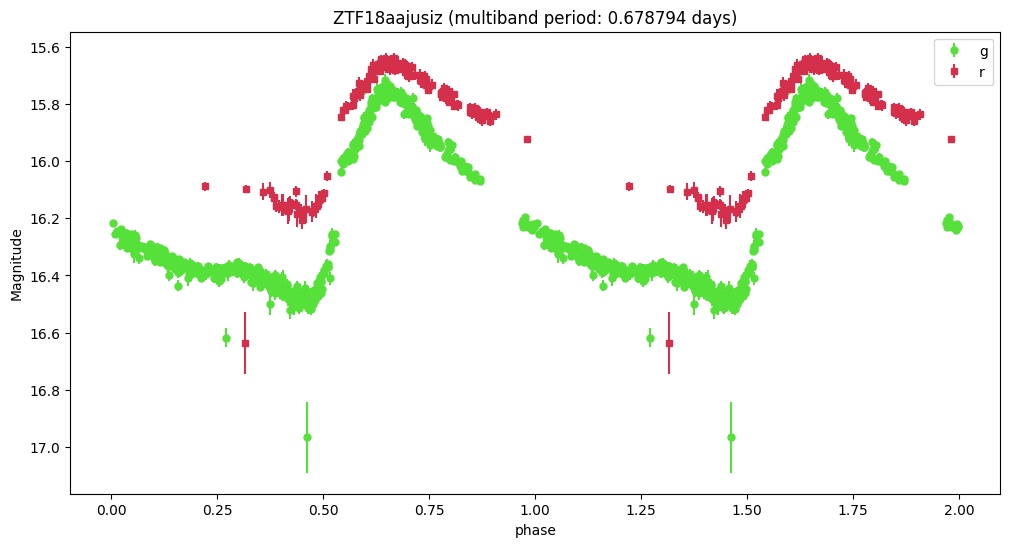

In [ ]:
period_mb_test = 0.678794
results = getVSdatacorr(lyraes[0])
plotperiod_multiband(lyraes[0], results["lc_det"], dofold=True, period_mb=period_mb_test)

Multiband period: 0.678804 days


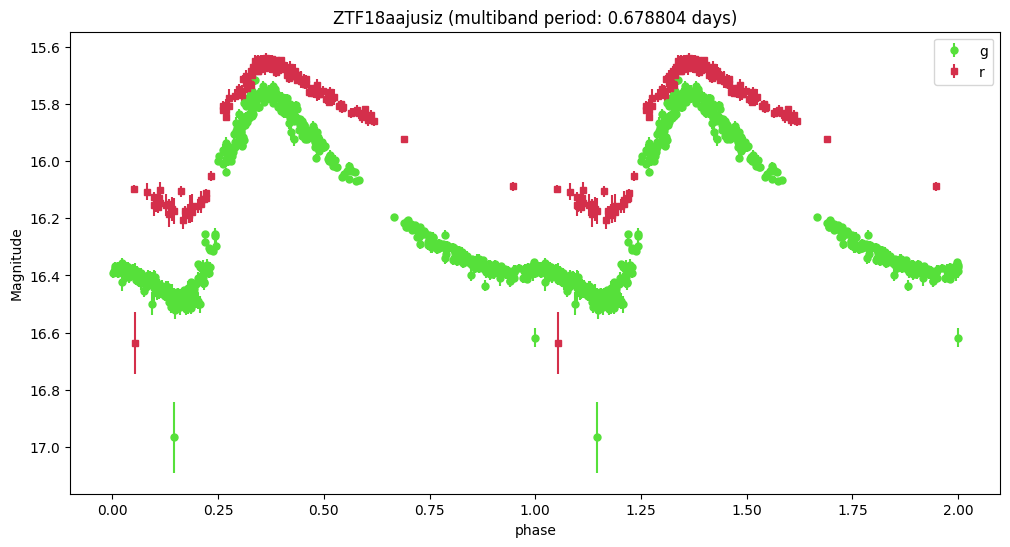

In [ ]:
mjds, mags, errs, fids = results["lc_det"][["mjd", "magpsf_corr", "sigmapsf_corr_ext", "fid"]].dropna().values.T

# Compute periodogram
my_per = P4J.MultiBandPeriodogram(method='MHAOV')
my_per.set_data(mjds, mags, errs, fids)
my_per.frequency_grid_evaluation(fmin=1e-3, fmax=10.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=5)

best_freq, best_per = my_per.get_best_frequencies()
freq_mb, per_mb = my_per.get_periodogram()
period_mb = 1.0 / best_freq[0]

print('Multiband period: %.6f days' % period_mb)

plotperiod_multiband(lyraes[0], results["lc_det"], dofold=True, period_mb=period_mb)

**Muestra**

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),


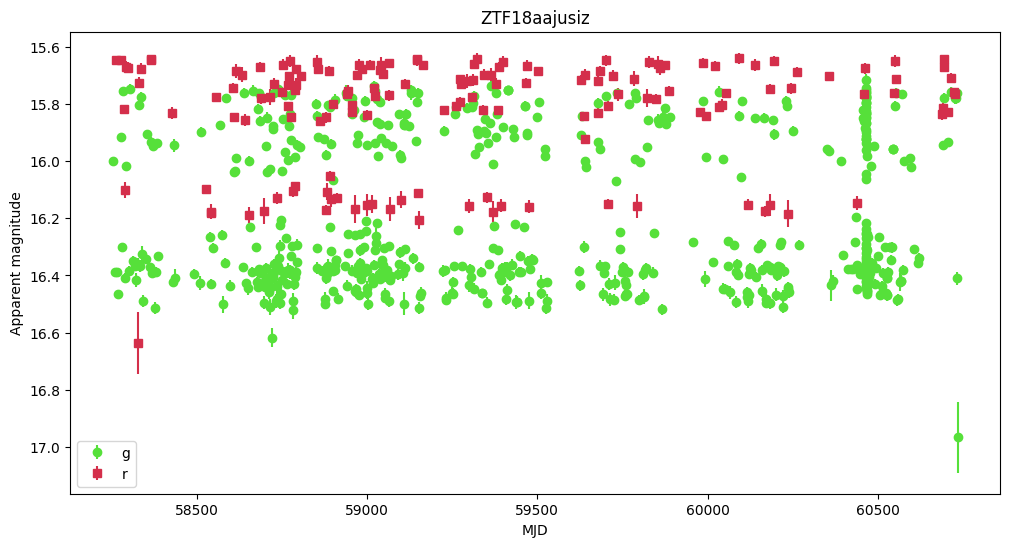

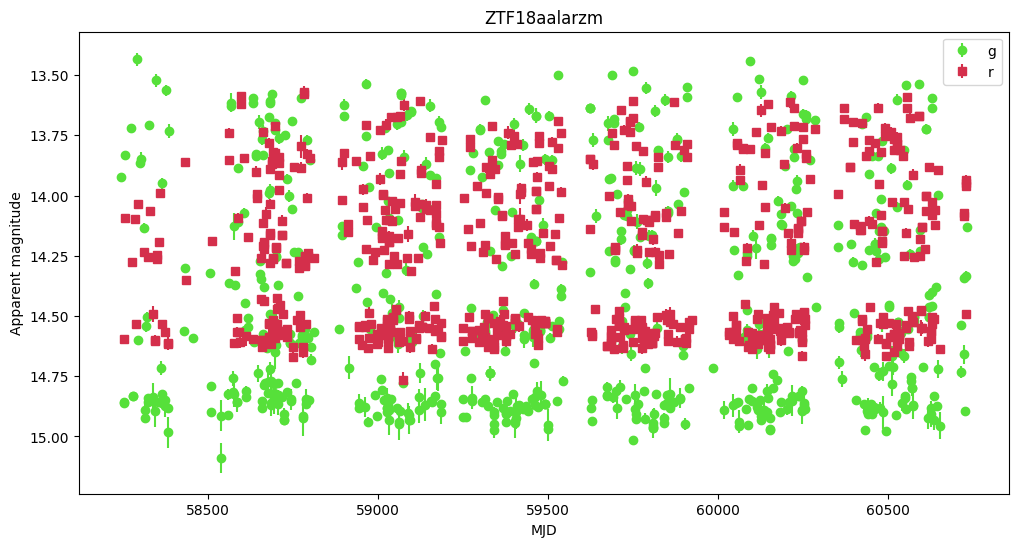

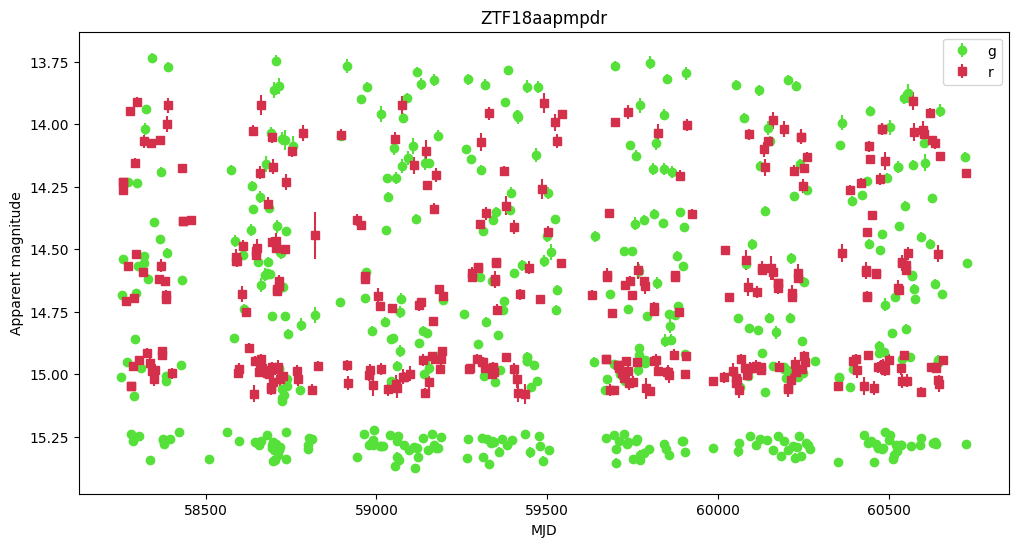

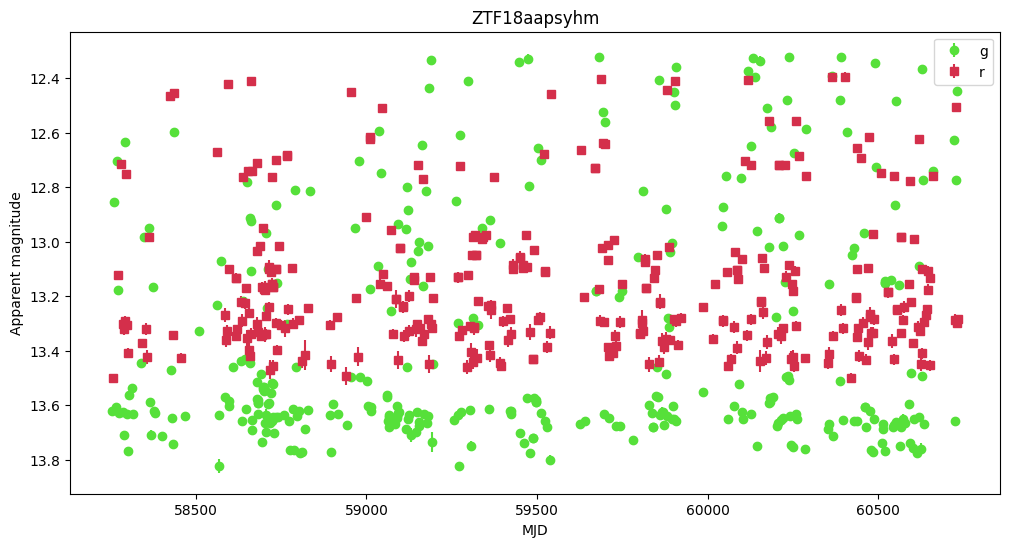

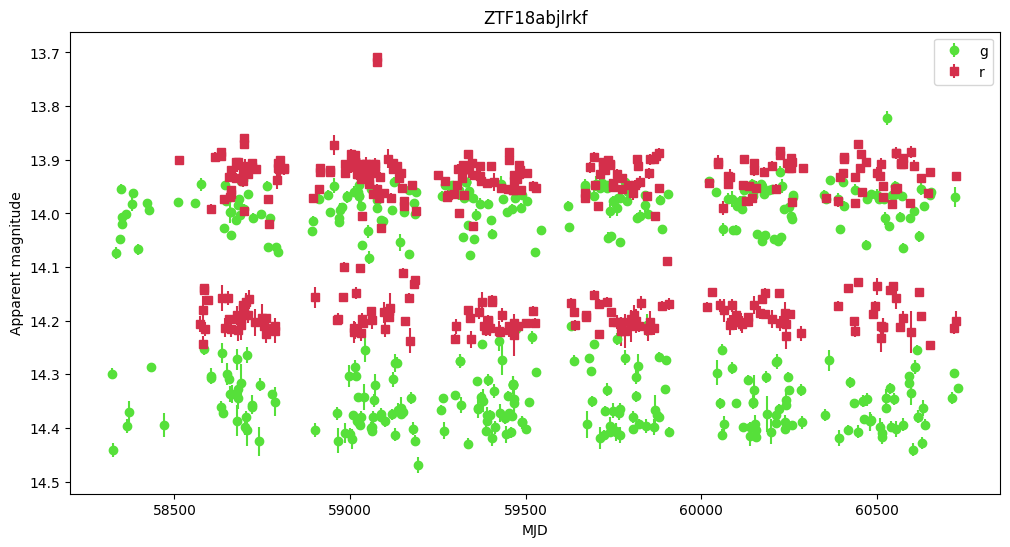

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid, doLC=True)

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-57-1266541ed3b0>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-57-1266541ed3b0>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a

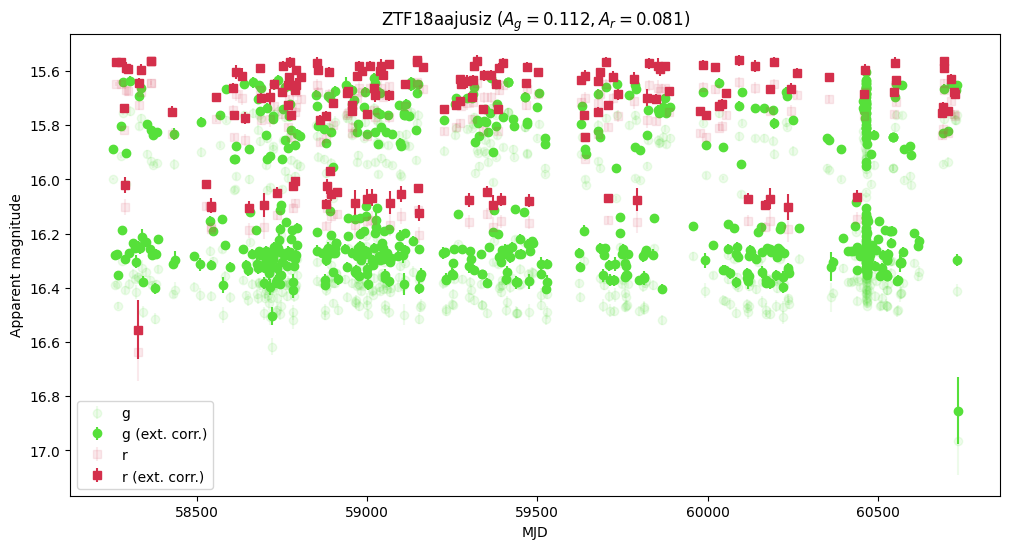

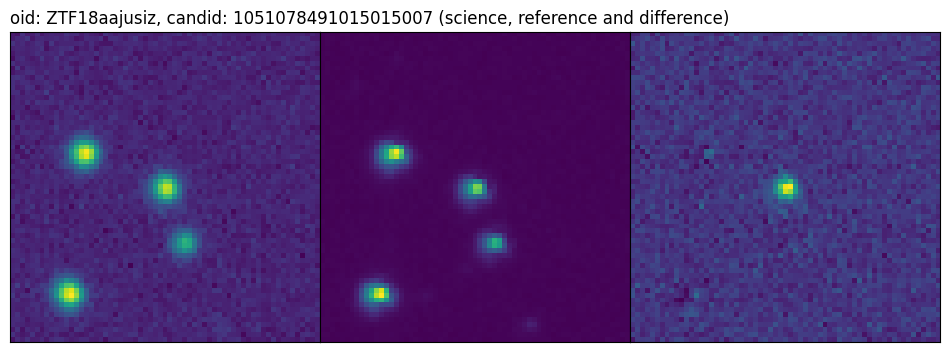

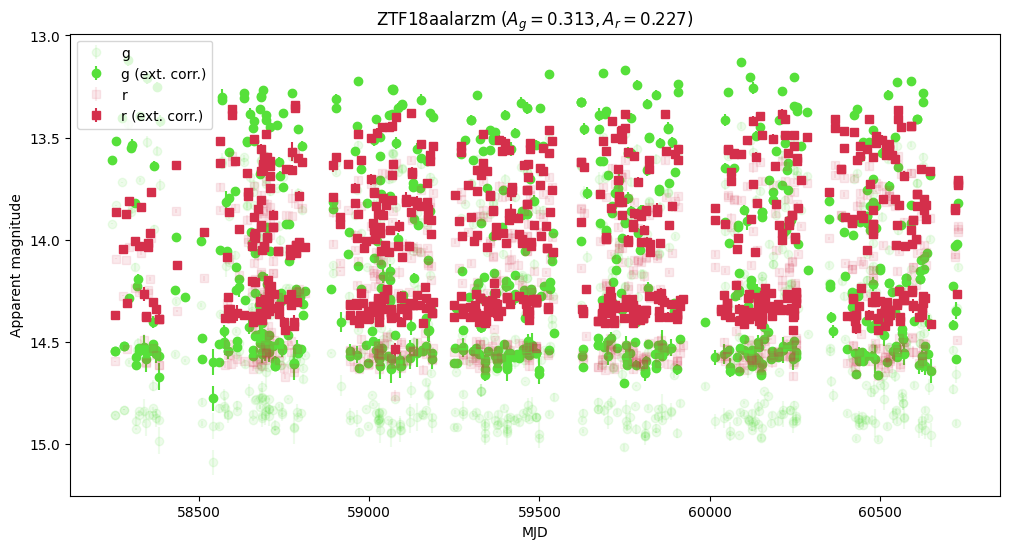

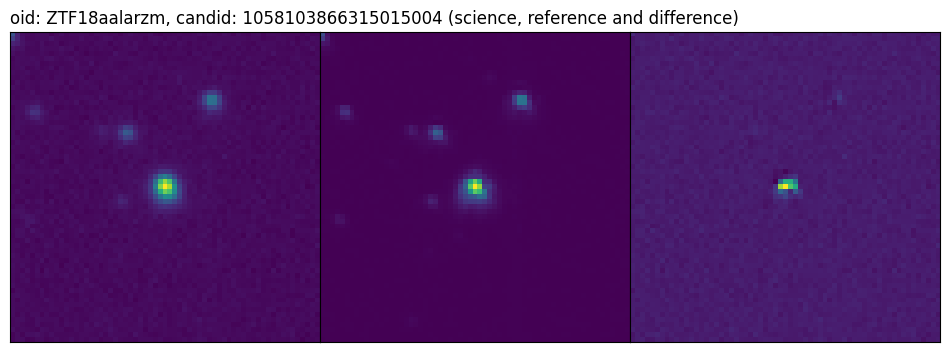

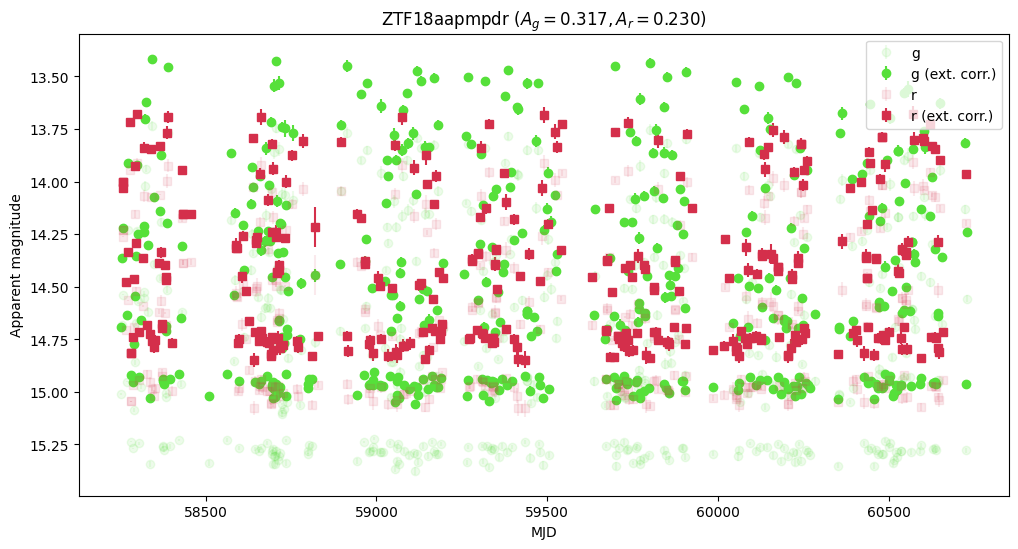

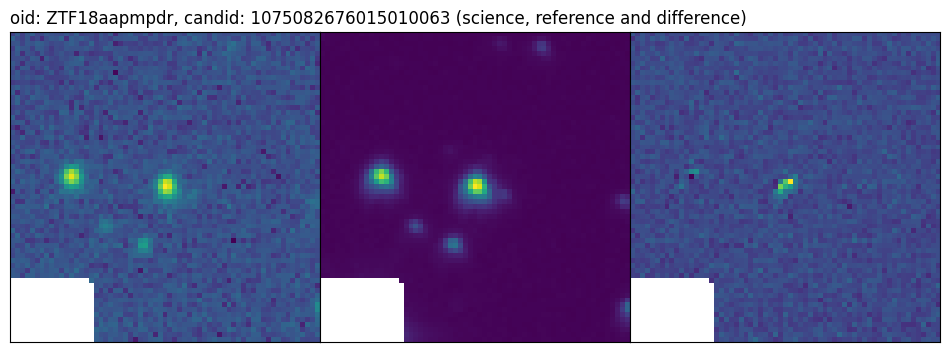

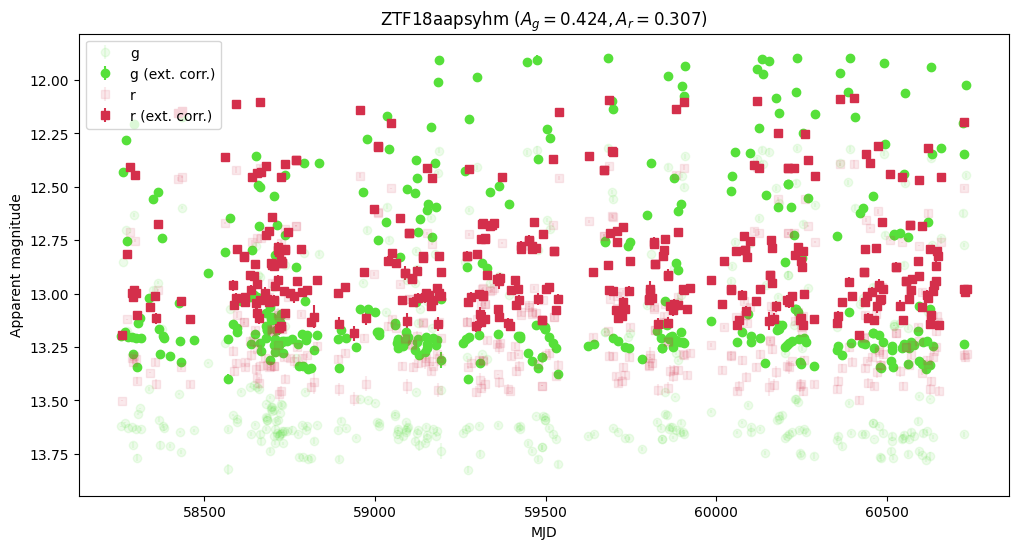

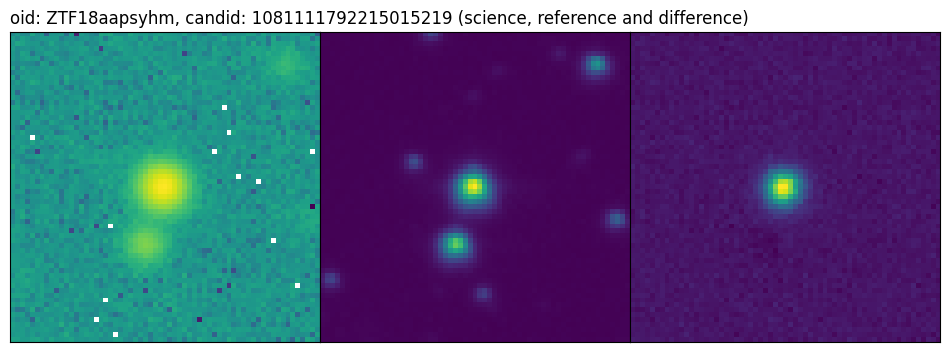

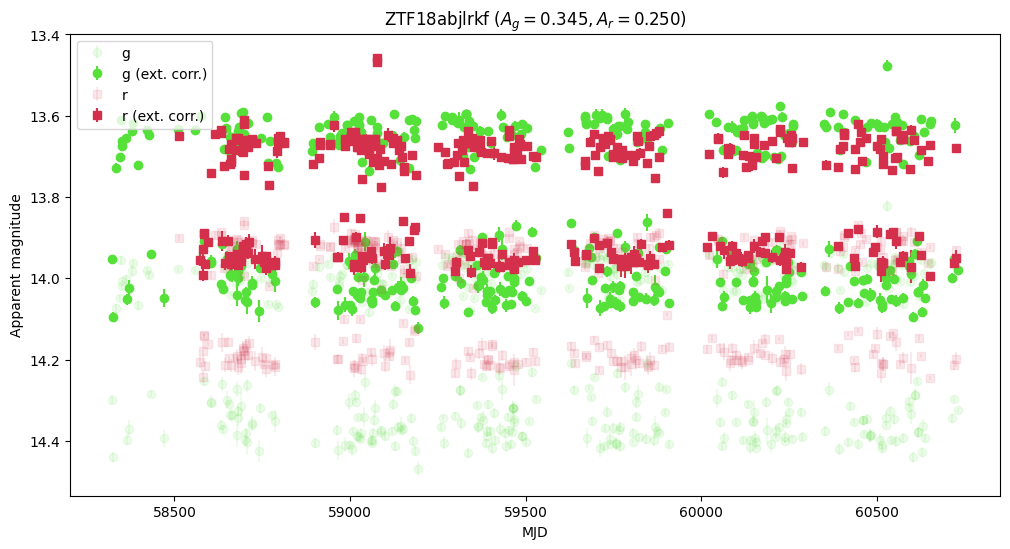

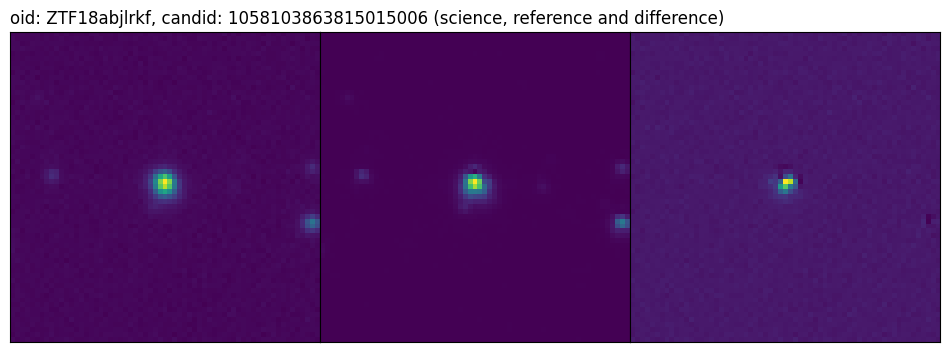

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid, doLC=True, doext=True, dostamp=True)

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
/usr/local/lib/python3.11/dist-packages/P4J/periodograms.py:64: RuntimeWarning: invalid value encountered in divide
  per_single_band.update({filter_name : (d2/d1)*per/(self.cython_per[filter_name].wvar-per)})
<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_sta

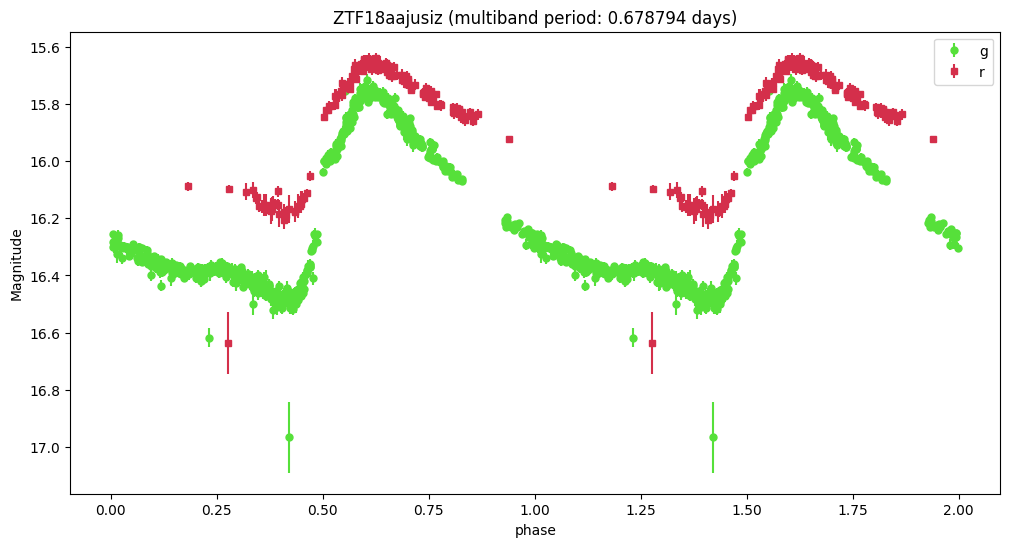

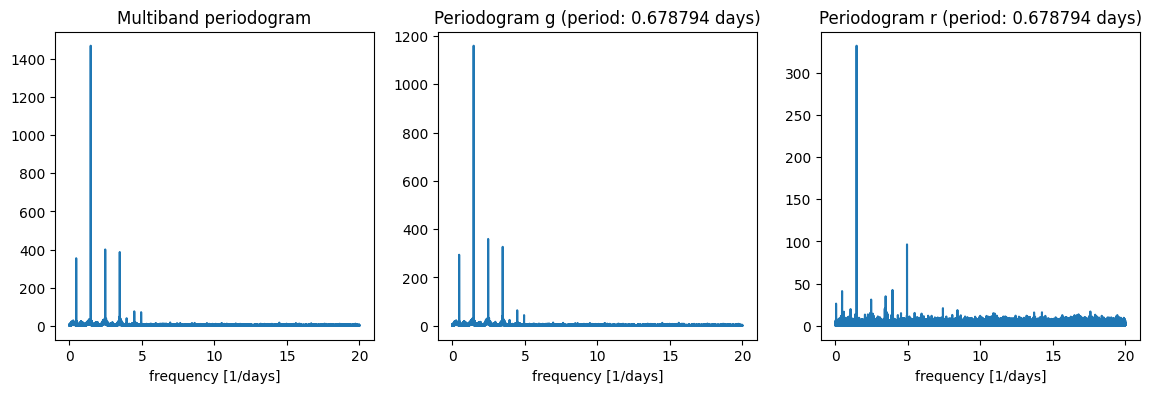

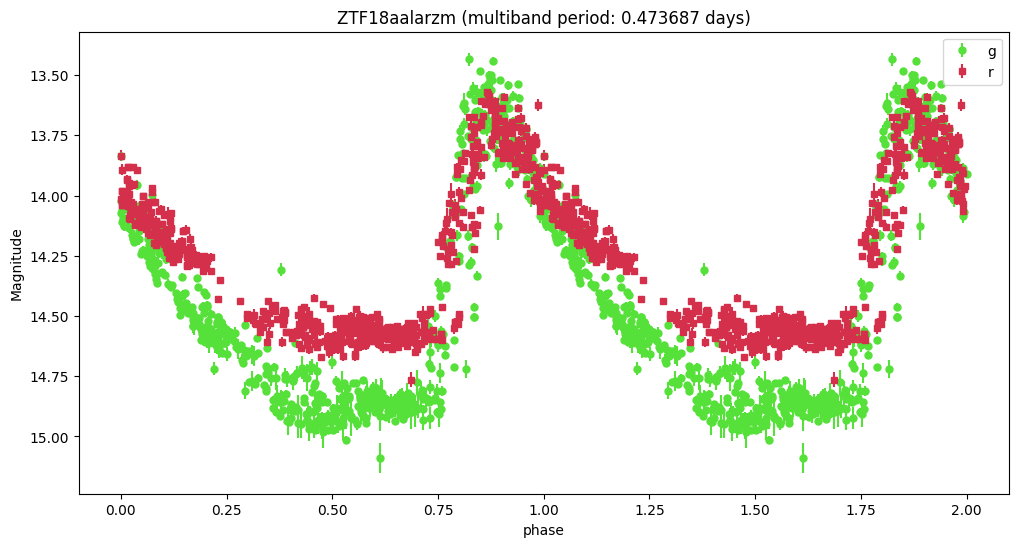

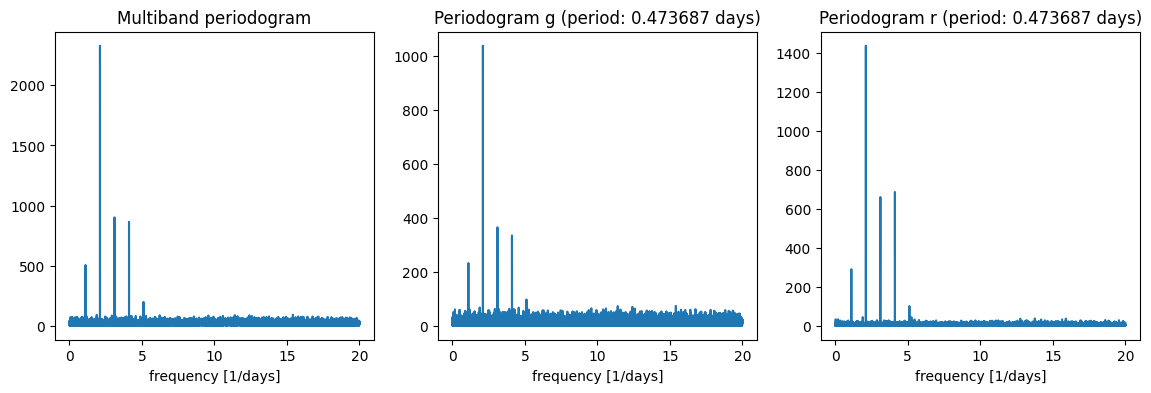

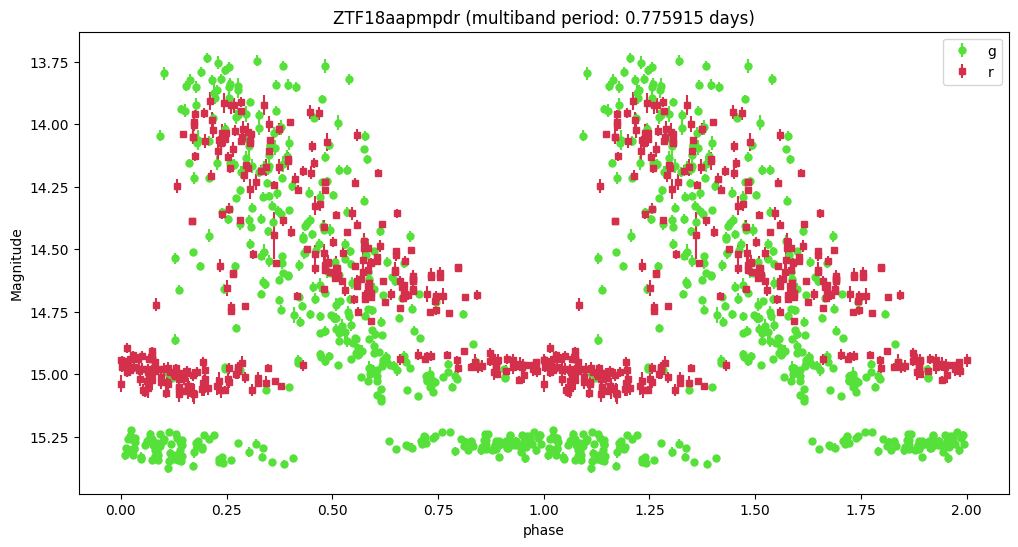

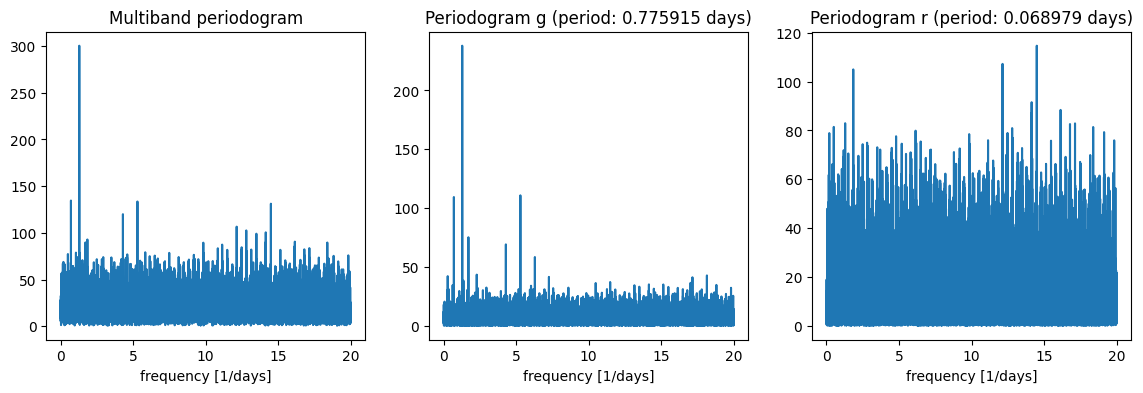

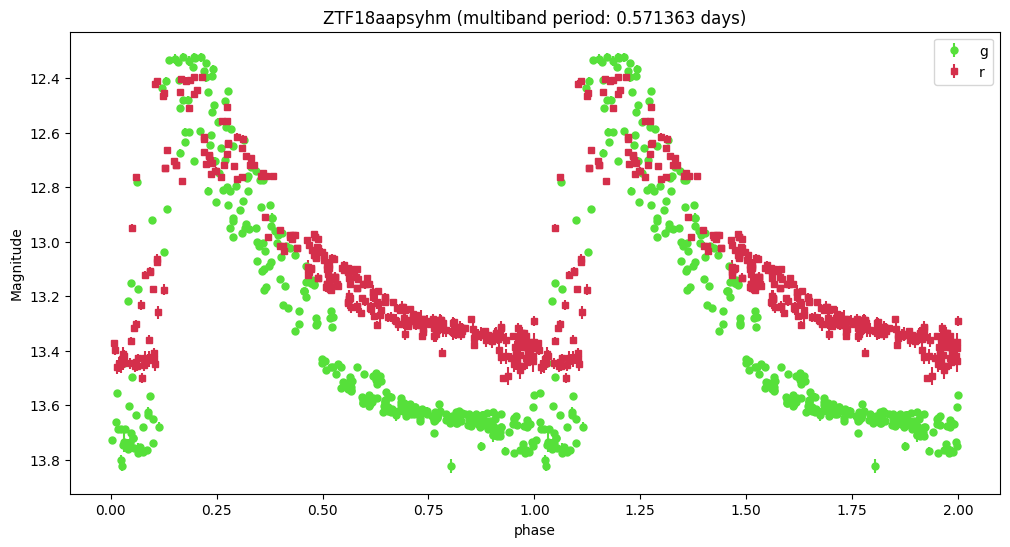

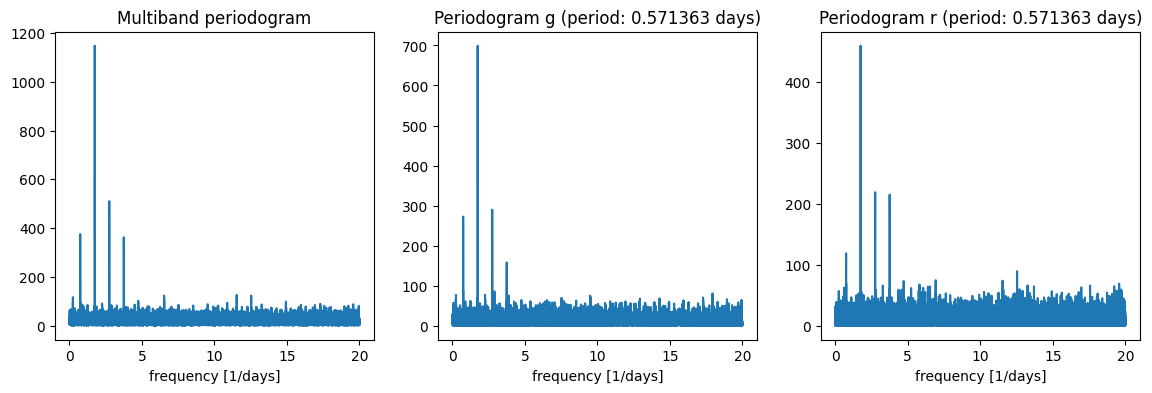

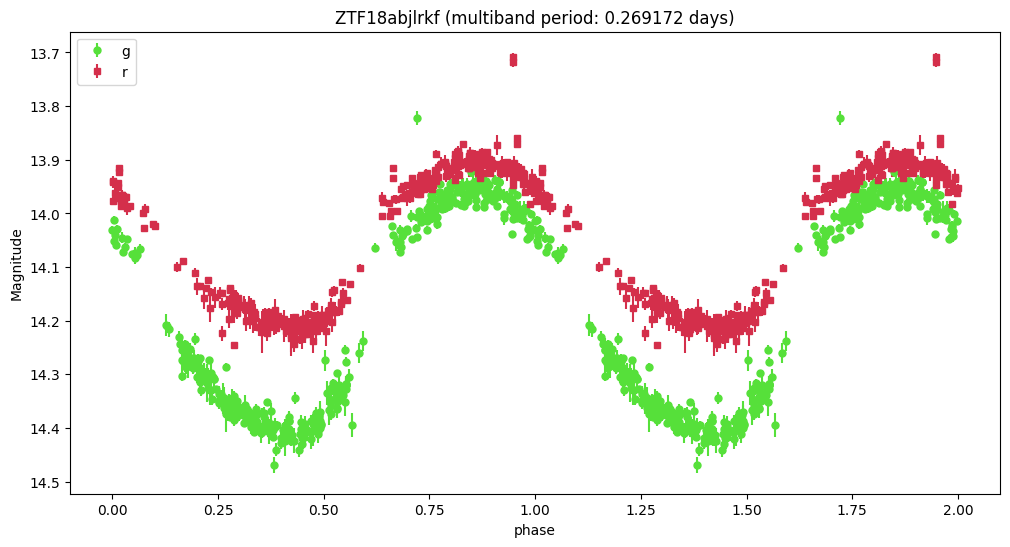

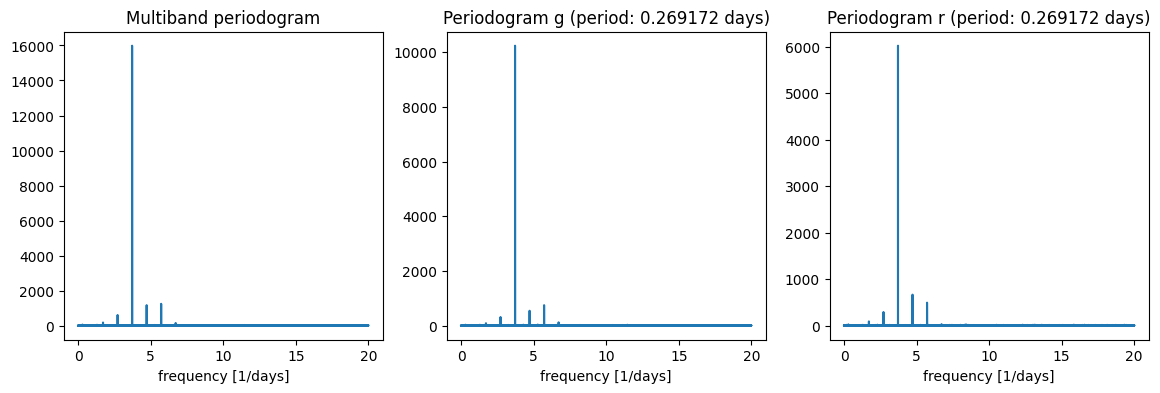

In [ ]:
for oid in lyraes:
    results = getVSdatacorr(oid)
    periodogram = getLCdata(oid, results, doplot=True, dofold=True, showperiodograms=True)

**Estimación distancias**

In [ ]:
feh = [-2.92, -1.14, -1.23, -1.66,-0.153]
afe = 0.3
f = 10**afe
mh = feh + np.log10(0.638 * f + 0.362)
logZ = mh - 1.765
#print("f =", f)
#print("[M/H] =", mh)
#print("log(Z) =", logZ)

noid = len(lyraes)
mg = np.zeros(noid)
mr = np.zeros(noid)
period_mb = np.zeros(noid)
period_g = np.zeros(noid)
period_r = np.zeros(noid)

for i, oid in enumerate(lyraes):
    results = getVSdatacorr(oid, doext=True)
    mg[i] = results["magstats"].magmean[0] - results["attenuation"]["g"]
    mr[i] = results["magstats"].magmean[1] - results["attenuation"]["r"]
    period_mb[i], freq_mb, per_mb, period, freq, per = doperiod_multiband(results["lc_det"])
    period_g[i] = period[1]
    period_r[i] = period[2]

Mg = 1.646 + 0.307 * logZ
Mr = 1.097 - 0.587 * np.log10(period_mb) + 0.238 * logZ

# Estimate distance using the m-d distance
dist_g = 10**(0.2 * (mg - Mg + 5.0))
dist_r = 10**(0.2 * (mr - Mr + 5.0))


<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-57-1266541ed3b0>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-57-1266541ed3b0>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a

In [ ]:
print(logZ)

[-4.47148826 -2.69148826 -2.78148826 -3.21148826 -1.70448826]


In [ ]:
g_r_max_corr_ext_att = np.zeros(noid)
g_r_mean_corr_ext_att = np.zeros(noid)

for i, oid in enumerate(lyraes):
    results = getVSdatacorr(oid, doext=True, doLC=False, dostamp=False)
    g_r_max_corr_ext_att[i] = results["stats"].g_r_max_corr - results["attenuation"]["g"] + results["attenuation"]["r"]
    g_r_mean_corr_ext_att[i] = results["stats"].g_r_mean_corr - results["attenuation"]["g"] + results["attenuation"]["r"]

<ipython-input-57-1266541ed3b0>:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  co = coordinates.SkyCoord(ra=float(VS_stats.meanra), dec=float(VS_stats.meandec), unit=(u.deg, u.deg),
<ipython-input-57-1266541ed3b0>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]),
<ipython-input-57-1266541ed3b0>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
<ipython-input-67-8ff7b74b5679>:6: FutureWarning: Calling float on a 

In [ ]:
g_r_max_corr_ext_att = np.array([0.072871,-0.221348,	-0.264549,0.069339,0.214])
g_r_mean_corr_ext_att = np.array([0.340664,0.059864,0.063131,0.202127,0.003])


In [ ]:
rrl_sample = pd.DataFrame(lyraes, columns=['oid'])
rrl_sample['Mg'] = Mg # Absolute Magnitude g, M_g
rrl_sample['Mr'] = Mr # Absolute Magnitude r, M_r
rrl_sample['mg'] = mg # Apparent Magnitude g, m_g
rrl_sample['mr'] = mr # Apparent Magnitude r, m_r
rrl_sample['dist_g'] = dist_g # Distance g filter (pc)
rrl_sample['dist_r'] = dist_r # Distance r filter (pc)
rrl_sample['period_mb'] = period_mb # Multiband period (days)
rrl_sample['period_g'] = period_g # g-band period (days)
rrl_sample['period_r'] = period_r # r-band period (days)
rrl_sample['g_r_max'] = g_r_max_corr_ext_att # g-r color @ max
rrl_sample['g_r_mean'] = g_r_mean_corr_ext_att # mean(g-r) color
rrl_sample = rrl_sample.set_index('oid')

In [ ]:
def plot_properties(propx, propy, propx_label, propy_label, dodiag=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(propx, propy, alpha=0.5,color="black")
    ax.set_xlabel("%s" % propx_label)
    ax.set_ylabel("%s" % propy_label)

    if dodiag:
        t = np.arange(min(propx)-0.1, max(propx)+0.1, 0.01)
        s = t
        ax.plot(t, s,color='gray', linestyle='--',label="y=x")
        ax.legend()

In [ ]:
display(rrl_sample)

,Mg,Mr,mg,mr,dist_g,dist_r,period_mb,period_g,period_r,g_r_max,g_r_mean
oid,,,,,,,,,,,
ZTF18aajusiz,0.273253,0.131555,17.684423,17.518880,30355.261535,30023.747926,0.678794,0.678794,0.678794,0.072871,0.340664
ZTF18aalarzm,0.819713,0.646912,15.583844,15.739069,8970.696816,10433.531494,0.473687,0.473687,0.473687,-0.221348,0.059864
ZTF18aapmpdr,0.792083,0.499685,16.017839,16.128505,11095.609890,13358.695502,0.775915,0.775915,0.068979,-0.264549,0.063131
ZTF18aapsyhm,0.660073,0.475358,14.361731,14.012803,5499.606024,5099.046114,0.571363,0.571363,0.571363,0.069339,0.202127
ZTF18abjlrkf,1.122722,1.025904,15.790893,16.154167,8582.902499,10608.464216,0.269172,0.269172,0.269172,0.214000,0.003000


In [ ]:
# Configurar pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Para asegurarte de ver todo el contenido de las celdas
pd.set_option('display.max_colwidth', None)

In [ ]:
oids = [
'ZTF18aajusiz', 'ZTF18aalarzm', 'ZTF18aapmpdr', 'ZTF18aapsyhm', 'ZTF18abjlrkf'
]
objects = alerce.query_objects(oid=oids, format="pandas")

In [ ]:
display(objects)

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18aajusiz,2272,5114,58205.500278,60735.406389,True,False,757,None,None,None,None,58252.432905,60735.406389,2482.973484,256.891322,58.849930,0.004777,0.002471,None,None,None,27.4.0
1,ZTF18aalarzm,2848,5120,58197.442766,60729.539294,True,False,1415,None,None,None,None,58244.445776,60729.539294,2485.093518,283.357962,43.154548,0.002618,0.001910,None,None,None,27.4.0
2,ZTF18aapmpdr,1957,3079,58216.517176,60727.540995,True,False,769,None,None,None,None,58252.442269,60727.540995,2475.098727,289.502032,50.754922,0.003384,0.002141,None,None,None,27.4.0
3,ZTF18aapsyhm,1815,3157,58216.517176,60733.535498,True,False,690,None,None,None,None,58255.435509,60733.535498,2478.099988,293.253734,46.239725,0.003623,0.002506,None,None,None,27.4.0
4,ZTF18abjlrkf,155,1970,58323.404363,60733.504711,True,False,824,None,None,None,None,58323.404363,60733.504711,2410.100347,287.598198,40.767887,0.003340,0.002529,None,None,None,27.4.0


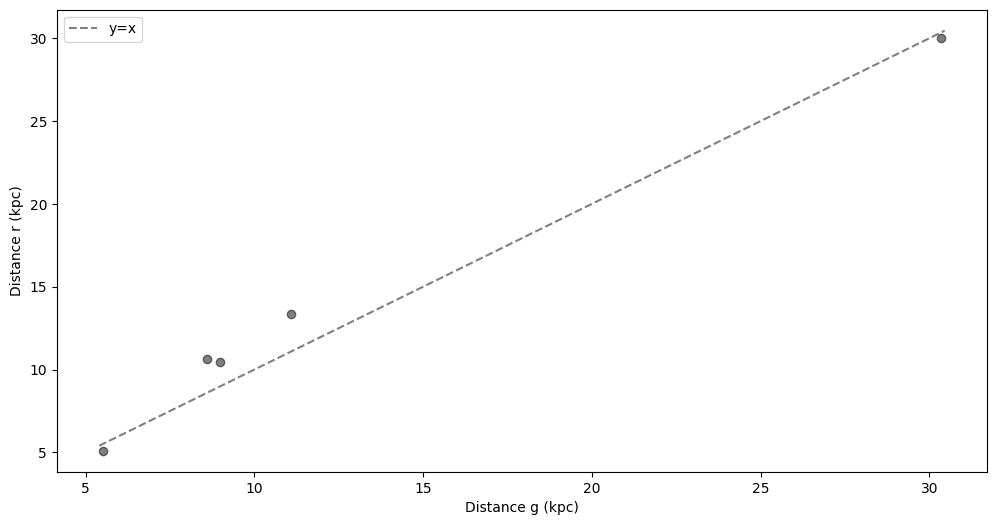

In [ ]:
plot_properties(propx=rrl_sample['dist_g']/1000., propy=rrl_sample['dist_r']/1000.,
                propx_label="Distance g (kpc)", propy_label="Distance r (kpc)", dodiag=True)

In [ ]:
print("mean(g-r) (mag) = ", g_r_mean_corr_ext_att)
gaiacolor = 0.3482 + 1.3463*g_r_mean_corr_ext_att - 0.031*g_r_mean_corr_ext_att**2 + 0.0067*g_r_mean_corr_ext_att**3
print("BR-BP (mag) = ", gaiacolor)
G = Mg - 0.0662 - 0.7854*(Mg-Mr) - 0.2859*(Mg-Mr)**2 + 0.0145*(Mg-Mr)**3
print("G (mag) = ", G)

mean(g-r) (mag) =  [0.340664 0.059864 0.063131 0.202127 0.003   ]
BR-BP (mag) =  [0.80350322 0.42868525 0.4330714  0.61911239 0.35223862]
G (mag) =  [0.09006468 0.6093332  0.47215239 0.4391347  0.97781472]


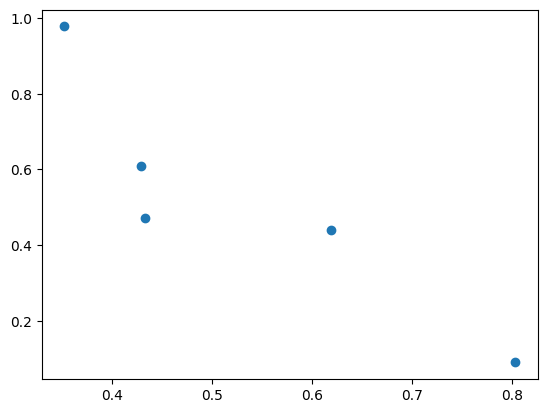

In [ ]:
plt.scatter(gaiacolor,G),0.4330714

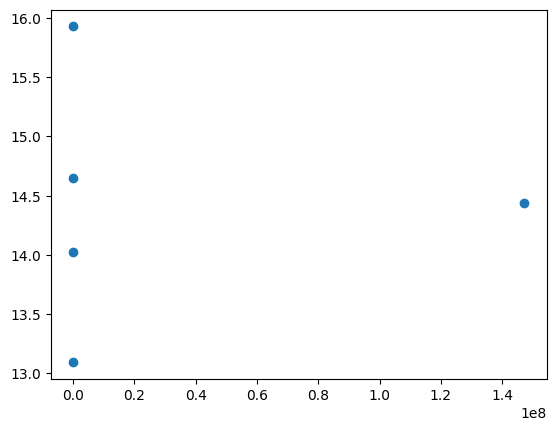

In [ ]:
BPP=np.array([16.166138,147153635,14.858464,13.35117,14.206913])
RPP=np.array([15.507432,13.962987,14.298996,12.650882,13.679546])
GG=np.array([15.927281,14.437781,14.6504,13.093862,14.024088])
colorcito=BPP-RPP
plt.scatter(colorcito,GG)

(17.850557600000002, 14.195596400000001)

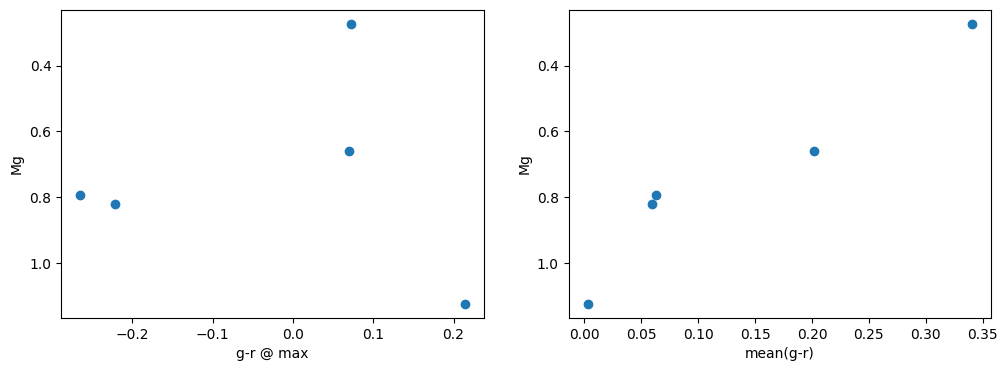

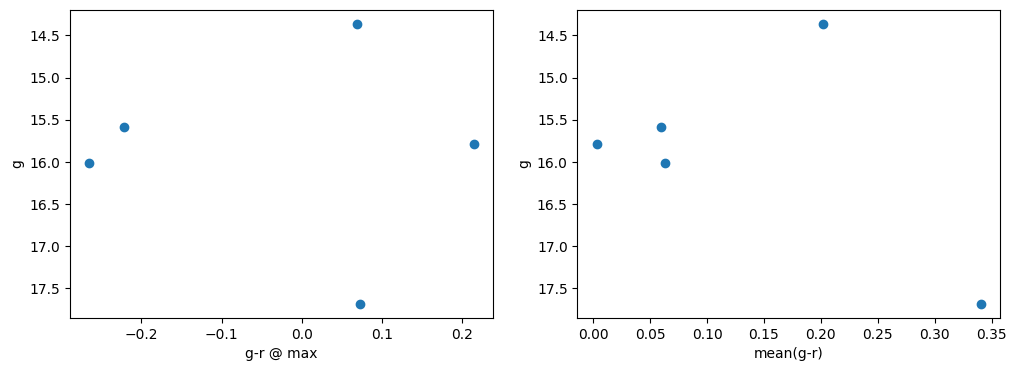

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].scatter(g_r_max_corr_ext_att, rrl_sample['Mg'])
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("Mg")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, rrl_sample['Mg'])
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("Mg")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].scatter(g_r_max_corr_ext_att, rrl_sample['mg'])
ax[0].set_xlabel("g-r @ max")
ax[0].set_ylabel("g")
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[1].scatter(g_r_mean_corr_ext_att, rrl_sample['mg'])
ax[1].set_xlabel("mean(g-r)")
ax[1].set_ylabel("g")
ax[1].set_ylim(ax[1].get_ylim()[::-1])

In [ ]:
print("mean(g-r) (mag) = ", g_r_mean_corr_ext_att)
gaiacolor = 0.3482 + 1.3463*g_r_mean_corr_ext_att - 0.031*g_r_mean_corr_ext_att**2 + 0.0067*g_r_mean_corr_ext_att**3
print("BR-BP (mag) = ", gaiacolor)
G = Mg - 0.0662 - 0.7854*(Mg-Mr) - 0.2859*(Mg-Mr)**2 + 0.0145*(Mg-Mr)**3
print("G (mag) = ", G)

mean(g-r) (mag) =  [0.340664 0.059864 0.063131 0.202127 0.003   ]
BR-BP (mag) =  [0.80350322 0.42868525 0.4330714  0.61911239 0.35223862]
G (mag) =  [0.09006468 0.6093332  0.47215239 0.4391347  0.97781472]


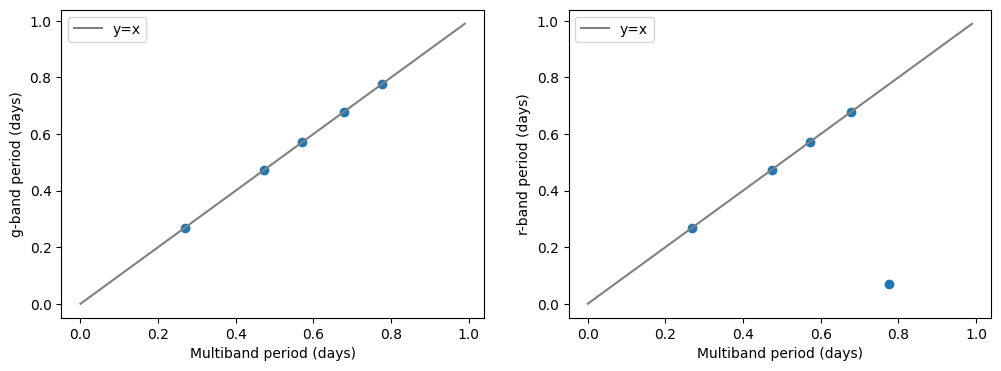

In [ ]:
labels = {1: 'g', 2: 'r'}
t = np.arange(0.0, 1.0, 0.01)
s = t
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

for idx, fid in enumerate([1, 2]):
    if fid==1:
        ax[idx].scatter(rrl_sample['period_mb'], rrl_sample['period_g'])
    else:
        ax[idx].scatter(rrl_sample['period_mb'], rrl_sample['period_r'])
    ax[idx].set_xlabel("Multiband period (days)")
    ax[idx].set_ylabel("%s-band period (days)" % (labels[fid]))
    ax[idx].plot(t, s, c='gray', label="y=x")
    ax[idx].legend()

# **Distribución**

In [ ]:
rr_ar= [256.891322, 283.357961, 289.502032, 293.253734, 287.598199]
rr_dec = [58.849930, 43.154548, 50.754922, 46.239725, 40.767887]


In [ ]:
def equatorial_to_galactic(ra,dec):
  ra_rad=np.radians(ra)
  dec_rad=np.radians(dec)

  X_eq= np.cos(ra_rad)*np.cos(dec_rad)
  Y_eq= np.sin(ra_rad)*np.cos(dec_rad)
  Z_eq= np.sin(dec_rad)

  l_rad=np.arctan2(Y_eq,X_eq)
  b_rad=np.arcsin(Z_eq/np.sqrt(X_eq**2+Y_eq**2+Z_eq**2))

  l=np.degrees(l_rad)
  b=np.degrees(b_rad)

  return l,b

In [ ]:
rr_l,rr_b=equatorial_to_galactic(rr_ar,rr_dec)


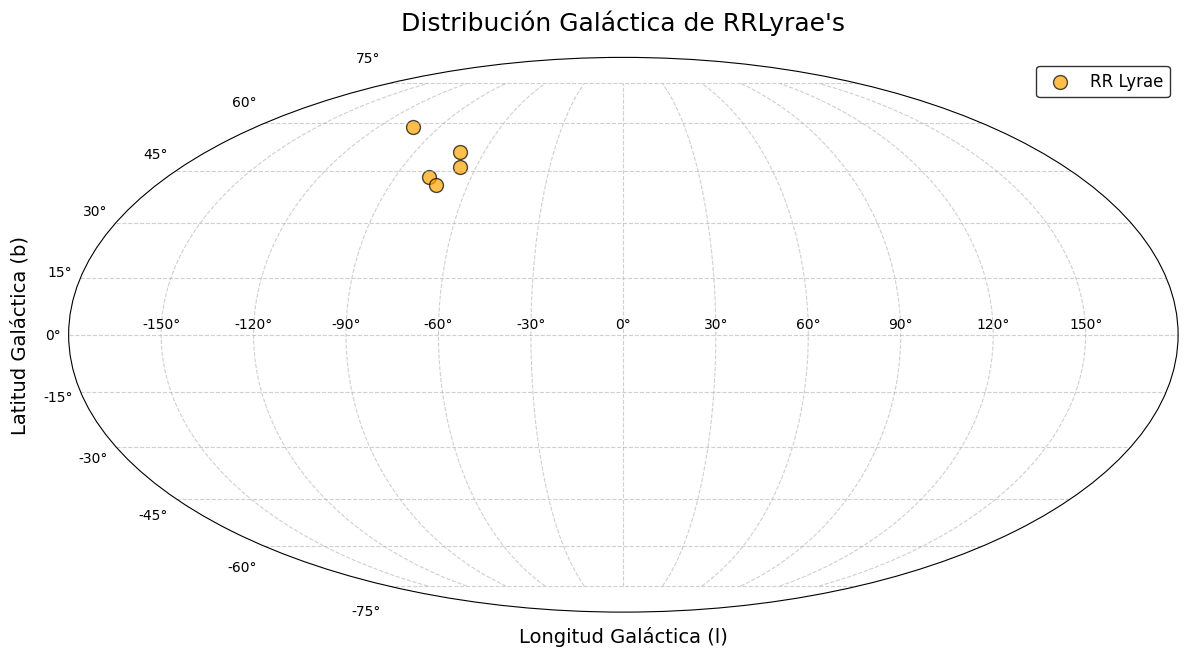

In [ ]:
l_rad_rr = np.radians(rr_l)
b_rad_rr = np.radians(rr_b)

# Crear el gráfico mejorado
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection="mollweide")  # Proyección Mollweide para mejor representación
ax.grid(True, linestyle='--', alpha=0.6)
# Graficar RR Lyrae
scatter_rr = ax.scatter(
    l_rad_rr, b_rad_rr, c="orange", alpha=0.7, s=100, label="RR Lyrae", edgecolor='black'
)

# Configurar el título, etiquetas y leyenda
plt.title("Distribución Galáctica de RRLyrae's", fontsize=18, pad=20)
ax.set_xlabel("Longitud Galáctica (l)", fontsize=14, labelpad=10)
ax.set_ylabel("Latitud Galáctica (b)", fontsize=14, labelpad=10)

# Leyenda bien posicionada
plt.legend(loc="upper right", fontsize=12, frameon=True, edgecolor='black')

# Ajustar la visualización y mostrar
plt.tight_layout()
plt.show()

# **hola**

In [ ]:
/home/excell/data.xlsx

In [ ]:
import pandas as pd

# Cargar el archivo Excel
file_path = "/home/excell/data.xlsx"
df = pd.read_excel(file_path)
ARS = df.iloc[0].values
print(ARS)
print(len(ARS))

['AR' 256.891322 283.357961 289.502032 293.253734 287.598199]
6


In [ ]:
import pandas as pd

# Cargar el archivo Excel
file_path = "/home/excell/data.xlsx"
df = pd.read_excel(file_path)



['AR', 256.891322, 283.357961, 289.502032, 293.253734, 287.598199]
['DEC', 58.84993, 43.154548, 50.754922, 46.239725, 40.767887]
['P [días]', 0.678794, 0.473687, 0.775915, 0.571363, 0.269172]
['g_mean [mag]', 17.792, 15.897, 16.335, 14.786, 16.136]
['r_mean [mag]', 17.6, 15.966, 16.359, 14.32, 16.404]
['A_g [mag]', 0.112, 0.313, 0.317, 0.424, 0.345]
['A_r [mag]', 0.081, 0.227, 0.23, 0.307, 0.25]
['d_g  [kpc]', 30.355, 8.97, 11.095, 5.499, 8.582]
['d_r  [kpc]', 30.023, 10.433, 13.358, 5.099, 10.608]
['[Fe/H]', -2.92, -1.14, -1.23, -1.66, -0.153]
['M_g [mag]', 0.273253, 0.819713, 0.792083, 0.660073, 1.122722]
['m_g [mag]', 17.684423, 15.583844, 16.017839, 14.361731, 15.790893]
['M_r [mag]', 0.131555, 0.646912, 0.499685, 0.475358, 1.025904]
['m_r [mag]', 17.51888, 15.739069, 16.128505, 14.012803, 16.154167]
['(g-r)_mean [mag]', 0.340664, 0.059864, 0.063131, 0.202127, 0.003]
['(BP-RP)_mean [mag]', 0.8035032, 0.42868526, '0.42868526', 0.4330714, 0.35223862]
['G_mean [mag]', 0.09006468, 0.60

In [ ]:
import pandas as pd

# Cargar el archivo Excel
file_path = "/home/excell/data.xlsx"
df = pd.read_excel(file_path)

# Obtener los datos sin la primera columna
listas = df.iloc[:, 1:].values.tolist()
# Mostrar las listas
#for i, lista in enumerate(listas):
    #print(f"Fila {i + 1}: {lista}")
print(listas)

[[256.891322, 283.357961, 289.502032, 293.253734, 287.598199], [58.84993, 43.154548, 50.754922, 46.239725, 40.767887], [0.678794, 0.473687, 0.775915, 0.571363, 0.269172], [17.792, 15.897, 16.335, 14.786, 16.136], [17.6, 15.966, 16.359, 14.32, 16.404], [0.112, 0.313, 0.317, 0.424, 0.345], [0.081, 0.227, 0.23, 0.307, 0.25], [30.355, 8.97, 11.095, 5.499, 8.582], [30.023, 10.433, 13.358, 5.099, 10.608], [-2.92, -1.14, -1.23, -1.66, -0.153], [0.273253, 0.819713, 0.792083, 0.660073, 1.122722], [17.684423, 15.583844, 16.017839, 14.361731, 15.790893], [0.131555, 0.646912, 0.499685, 0.475358, 1.025904], [17.51888, 15.739069, 16.128505, 14.012803, 16.154167], [0.340664, 0.059864, 0.063131, 0.202127, 0.003], [0.8035032, 0.42868526, '0.42868526', 0.4330714, 0.35223862], [0.09006468, 0.6093332, 0.47215239, 0.4391347, 0.97781472], [0.483402, 5.504915, 0.1531858, 11.896873, -3.41793], [-5.168265, 1.672719, 0.726333, -5.06362, -5.239723], [6533, 6139, 6958.11, 6317, 7043], ['[6180,6816]', '[5810,6516]

In [ ]:
ARS=listas[0]
DECS=listas[1]
PS=listas[2] # días
g_means=listas[3] # mag
r_means=listas[4] # mag
A_gs=listas[5] # mag
A_rs=listas[6] # mag
d_gs=listas[7] # kpc
d_rs=listas[8] # kpc
fehs=listas[9]  # mag
M_gs=listas[10] # mag
m_gs=listas[11] # mag
M_rs=listas[12] # mag
m_rs=listas[13] # mag
g_r_means=listas[14] # mag
BPRPs=listas[15] # mag
G_means=listas[16] # mag
PMDEC=listas[17] # mas/yr
PMAR=listas[18] # mas/yr
T_effs=listas[19] # K
T_effranges=listas[20] # K
V=listas[21] # mag

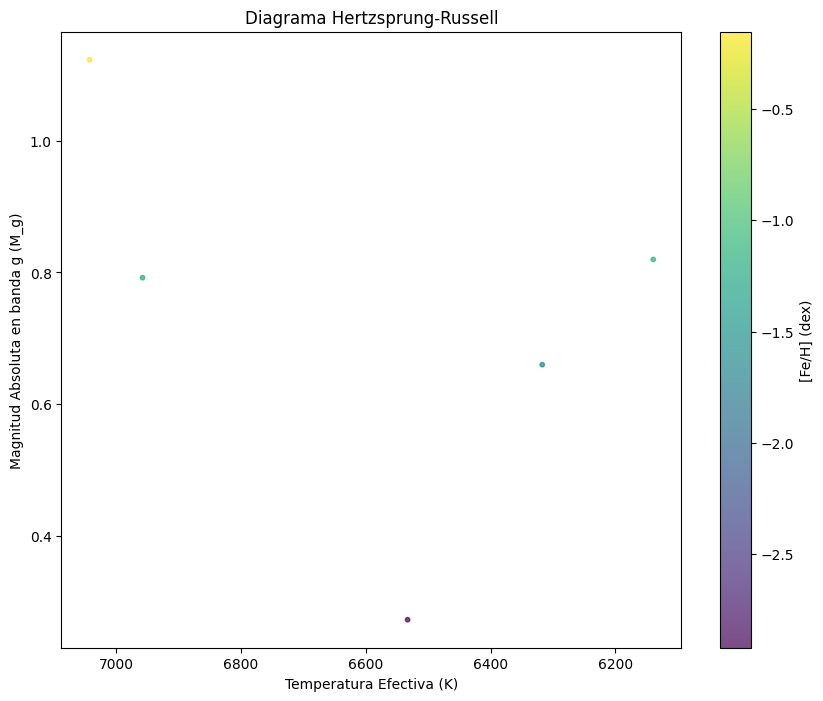

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.scatter(T_effs, M_gs, c=fehs, s=10, cmap='viridis', alpha=0.7)
plt.colorbar(label='[Fe/H] (dex)')
plt.gca().invert_xaxis()  # Temperatura decreciente
plt.xlabel('Temperatura Efectiva (K)')
plt.ylabel('Magnitud Absoluta en banda g (M_g)')
plt.title('Diagrama Hertzsprung-Russell')
plt.show()

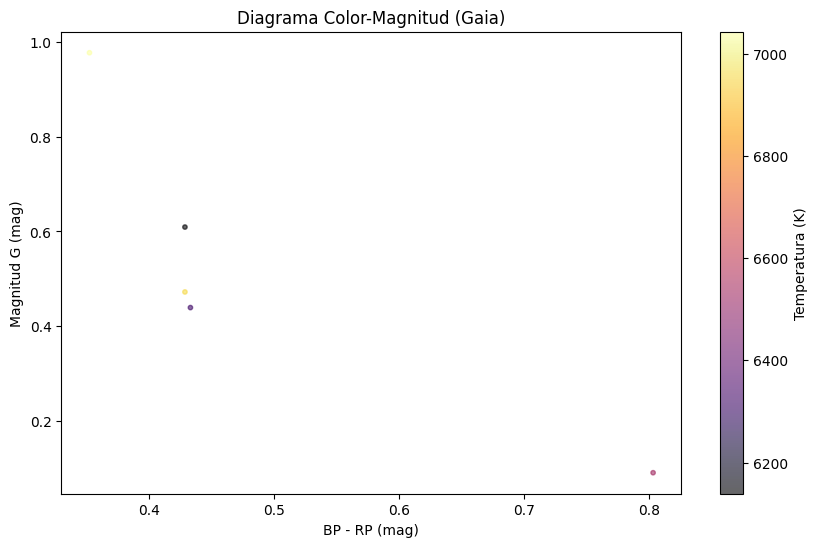

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(BPRPs, G_means, c=T_effs, s=10, cmap='inferno', alpha=0.6)
plt.colorbar(label='Temperatura (K)')
plt.xlabel('BP - RP (mag)')
plt.ylabel('Magnitud G (mag)')
plt.title('Diagrama Color-Magnitud (Gaia)')
plt.show()

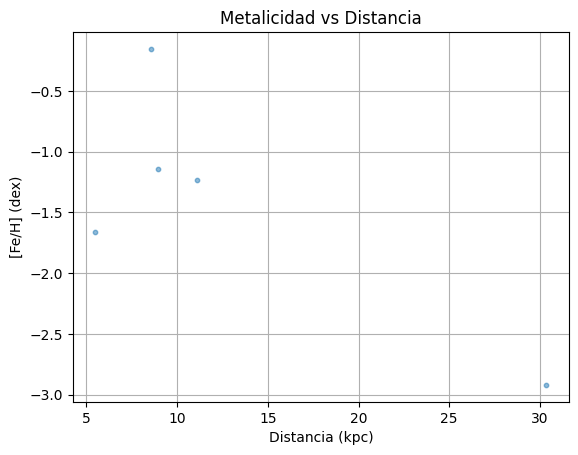

In [ ]:
plt.scatter(d_gs, fehs, s=10, alpha=0.5)
plt.xlabel('Distancia (kpc)')
plt.ylabel('[Fe/H] (dex)')
plt.title('Metalicidad vs Distancia')
plt.grid(True)
plt.show()

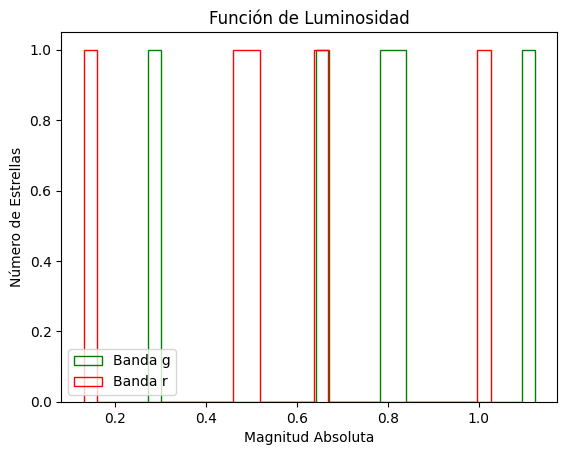

In [ ]:
plt.hist(M_gs, bins=30, histtype='step', color='g', label='Banda g')
plt.hist(M_rs, bins=30, histtype='step', color='r', label='Banda r')
plt.xlabel('Magnitud Absoluta')
plt.ylabel('Número de Estrellas')
plt.legend()
plt.title('Función de Luminosidad')
plt.show()

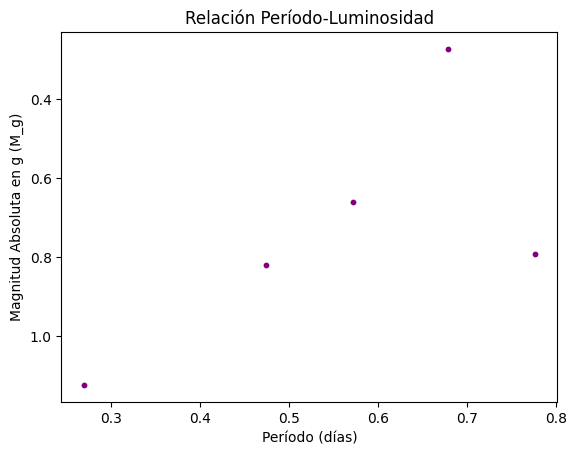

In [ ]:
plt.scatter(PS, M_gs, c='purple', s=10)
plt.xlabel('Período (días)')
plt.ylabel('Magnitud Absoluta en g (M_g)')
plt.title('Relación Período-Luminosidad')
plt.gca().invert_yaxis()
plt.show()

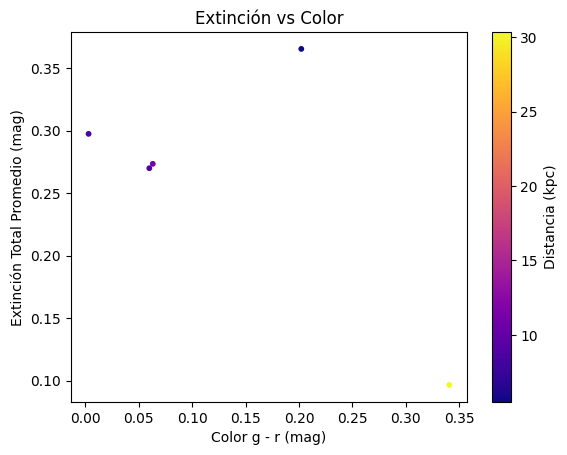

In [ ]:
A_tot = np.mean([A_gs, A_rs], axis=0)
plt.scatter(g_r_means, A_tot, c=d_gs, s=10, cmap='plasma')
plt.colorbar(label='Distancia (kpc)')
plt.xlabel('Color g - r (mag)')
plt.ylabel('Extinción Total Promedio (mag)')
plt.title('Extinción vs Color')
plt.show()

In [ ]:
mean_feh = np.mean(fehs)
print(f"Metalicidad promedio: {mean_feh:.2f} dex")

Metalicidad promedio: -1.42 dex


In [ ]:
df = pd.DataFrame({
    'ARS': ARS, 'DECS': DECS, 'PS': PS, 'g_means': g_means, 'r_means': r_means,
    'A_gs': A_gs, 'A_rs': A_rs, 'd_gs': d_gs, 'd_rs': d_rs, 'fehs': fehs,
    'M_gs': M_gs, 'm_gs': m_gs, 'M_rs': M_rs, 'm_rs': m_rs, 'g_r_means': g_r_means,
    'BPRPs': BPRPs, 'G_means': G_means, 'PMDEC': PMDEC, 'PMAR': PMAR,
    'T_effs': T_effs, 'T_effranges': T_effranges, 'V': V
})

In [ ]:
!pip install isochrones

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.6/997.6 kB 40.0 MB/s eta 0:00:00
  Created wheel for isochrones: filename=isochrones-2.1-py3-none-any.whl size=93760 sha256=a894c2ea1aacbae644d0e40e2e16e87ae04bf24c2503d79bfb01a1d26adc298d
  Stored in directory: /root/.cache/pip/wheels/53/64/c1/c070a8a6de96ba901c4c45285a0479613a94aa211f0cf8fe60
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=8c37bc0f34bbe2e3970a5dab0724f898d86614b38c2b3978710f7457c2c7daaa
  Stored in directory: /root/.cache/pip/wheels/71/c1/da/23077eb3b87d24d6f3852ed1ed1a1ac2d3c885ad6ebd2b4a07
Successfully built isochrones asciitree


In [ ]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from isochrones import get_ichrone
from isochrones.mist import MIST_Isochrone

# Suponiendo que tus datos están en un DataFrame llamado 'df'
# con columnas 'g_r_means' (color g-r) y 'M_gs' (magnitud absoluta en banda g)

# Inicializar el modelo de isócronas MIST
mist = MIST_Isochrone()


   g_r_means      M_gs  Masa_estimada  Edad_estimada
0   0.340664  0.273253            NaN            NaN
1   0.059864  0.819713            NaN            NaN
2   0.063131  0.792083            NaN            NaN
3   0.202127  0.660073            NaN            NaN
4   0.003000  1.122722            NaN            NaN


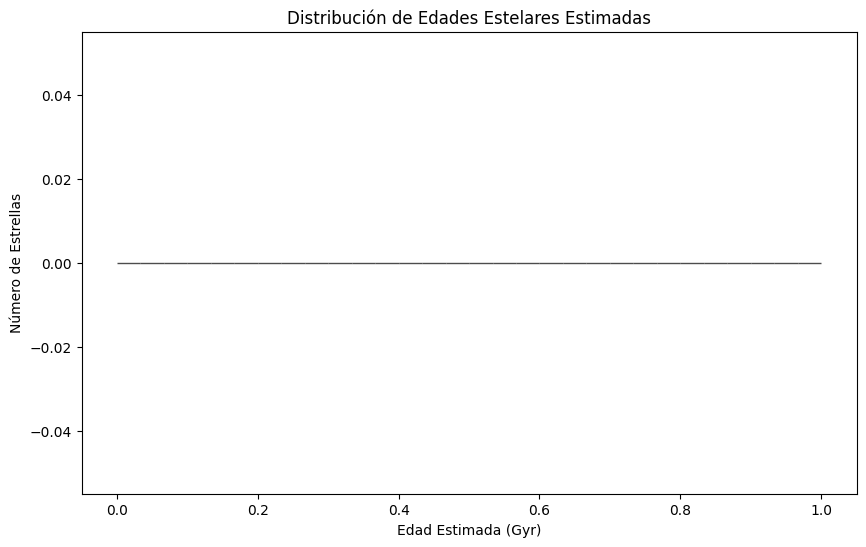

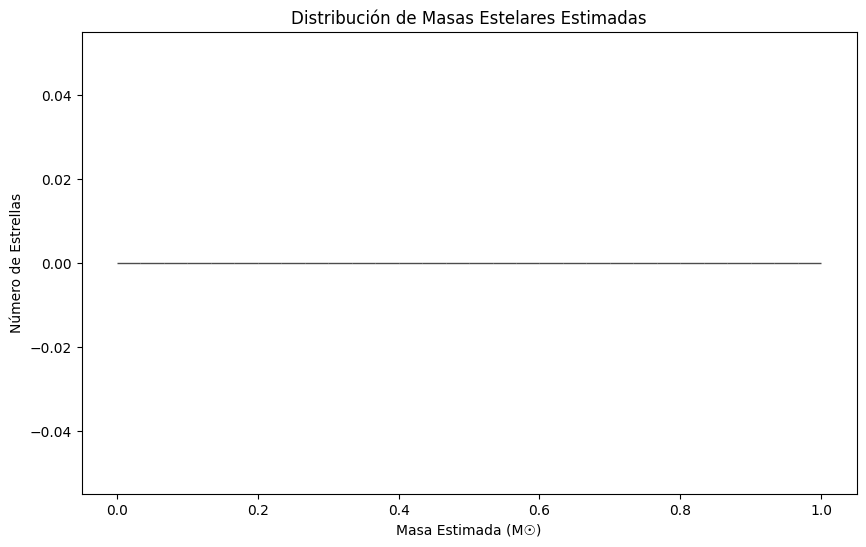

In [ ]:
# Función para estimar masa y edad a partir de color y magnitud
def estimar_parametros(color, magnitud):
    try:
        # Obtener la isócrona que mejor se ajusta
        iso_params = mist.get_isochrone(magnitud, color, bands=['g', 'r'])
        # Extraer masa y edad
        masa = iso_params['mass'][0]
        edad = iso_params['age'][0]
        return masa, edad
    except:
        return np.nan, np.nan

# Aplicar la función a cada estrella en el DataFrame
df['Masa_estimada'], df['Edad_estimada'] = zip(*df.apply(lambda row: estimar_parametros(row['g_r_means'], row['M_gs']), axis=1))

# Mostrar las primeras filas del DataFrame con las nuevas columnas
print(df[['g_r_means', 'M_gs', 'Masa_estimada', 'Edad_estimada']].head())

# Histograma de las edades estimadas
plt.figure(figsize=(10, 6))
plt.hist(df['Edad_estimada'].dropna(), bins=30, color='c', edgecolor='k', alpha=0.7)
plt.xlabel('Edad Estimada (Gyr)')
plt.ylabel('Número de Estrellas')
plt.title('Distribución de Edades Estelares Estimadas')
plt.show()

# Histograma de las masas estimadas
plt.figure(figsize=(10, 6))
plt.hist(df['Masa_estimada'].dropna(), bins=30, color='m', edgecolor='k', alpha=0.7)
plt.xlabel('Masa Estimada (M☉)')
plt.ylabel('Número de Estrellas')
plt.title('Distribución de Masas Estelares Estimadas')
plt.show()

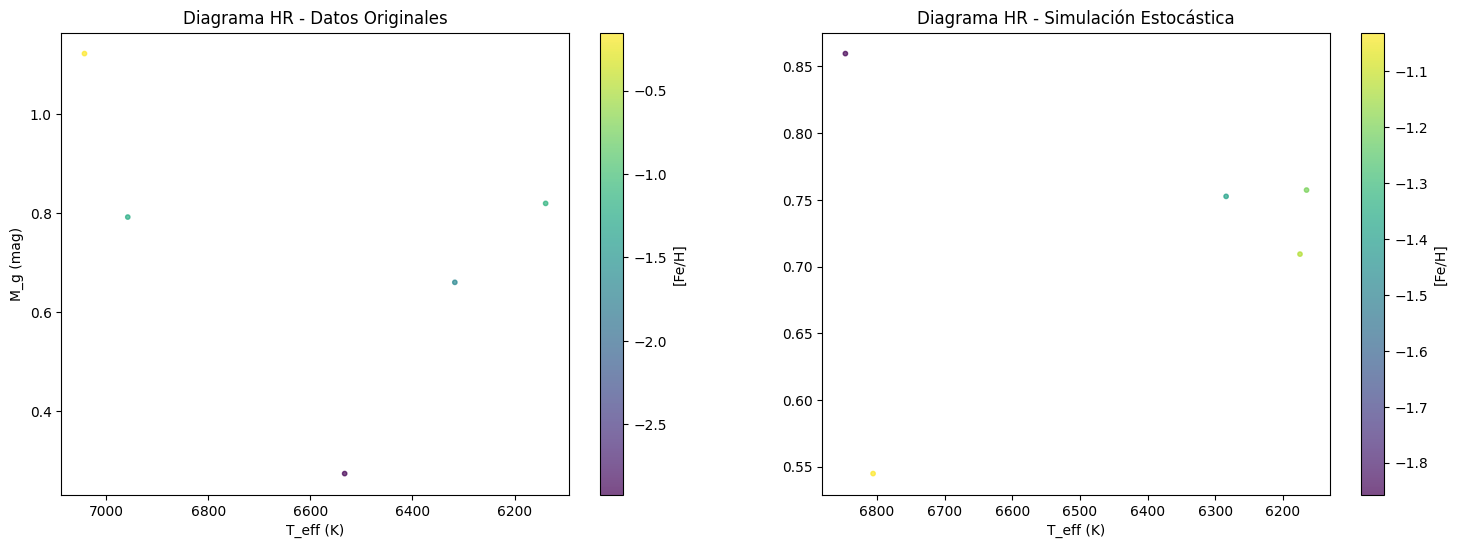

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

# Limpiar datos originales (eliminar NaNs)
mask = ~np.isnan(T_effs) & ~np.isnan(M_gs) & ~np.isnan(fehs)
T_eff_clean = np.array(T_effs)[mask]
M_g_clean = np.array(M_gs)[mask]
fehs_clean = np.array(fehs)[mask]

# Crear matriz de datos para el KDE [T_eff, M_g, feh]
data_original = np.vstack([T_eff_clean, M_g_clean, fehs_clean]).T

# Escalar datos para el KDE
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_original)

# Entrenar modelo KDE
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')  # Ajusta el bandwidth según necesidad
kde.fit(data_scaled)

# Generar muestras sintéticas (mismo número que datos originales)
n_samples = len(T_eff_clean)
samples_scaled = kde.sample(n_samples)
samples = scaler.inverse_transform(samples_scaled)

# Extraer parámetros simulados
T_eff_sim = samples[:, 0]
M_g_sim = samples[:, 1]
feh_sim = samples[:, 2]

# Gráficos comparativos
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Diagrama HR Original
sc1 = ax[0].scatter(T_eff_clean, M_g_clean, c=fehs_clean, s=10, cmap='viridis', alpha=0.7)
ax[0].set_title('Diagrama HR - Datos Originales')
ax[0].set_xlabel('T_eff (K)')
ax[0].set_ylabel('M_g (mag)')
ax[0].invert_xaxis()
plt.colorbar(sc1, ax=ax[0], label='[Fe/H]')

# Diagrama HR Simulado
sc2 = ax[1].scatter(T_eff_sim, M_g_sim, c=feh_sim, s=10, cmap='viridis', alpha=0.7)
ax[1].set_title('Diagrama HR - Simulación Estocástica')
ax[1].set_xlabel('T_eff (K)')
ax[1].invert_xaxis()
plt.colorbar(sc2, ax=ax[1], label='[Fe/H]')

plt.show()